## DeepONet Solver for 1D Derivative Problem

Implementation for vanilla DeepONet solver on the 1D derivative example, a few difference from Tyler's B2B implemtation

* everything computed on a regular grid (for both input function and output function)
* netwrok definition not entirely the same but can be modified to match
* domain and polynomial setup are implemented as hyperparameters and currently not 100% the same, but should not be an issue for what we need this for


Still need:
* code for deep sets
* regularization? if any?
* orthogonality test not implemented yet


Epoch 0, Loss: 1.474623
Epoch 1000, Loss: 0.013998
Epoch 2000, Loss: 0.009851
Epoch 3000, Loss: 0.006887
Epoch 4000, Loss: 0.007575
Epoch 5000, Loss: 0.005692
Epoch 6000, Loss: 0.005010
Epoch 7000, Loss: 0.003541
Epoch 8000, Loss: 0.002806
Epoch 9000, Loss: 0.007710
Epoch 10000, Loss: 0.003133
Epoch 11000, Loss: 0.002176
Epoch 12000, Loss: 0.002766
Epoch 13000, Loss: 0.001925
Epoch 14000, Loss: 0.001782
Epoch 15000, Loss: 0.002016
Epoch 16000, Loss: 0.002234
Epoch 17000, Loss: 0.001359
Epoch 18000, Loss: 0.003709
Epoch 19000, Loss: 0.001328
Epoch 20000, Loss: 0.001305
Epoch 21000, Loss: 0.001356
Epoch 22000, Loss: 0.001497
Epoch 23000, Loss: 0.002047
Epoch 24000, Loss: 0.001230
Epoch 25000, Loss: 0.001147
Epoch 26000, Loss: 0.001019
Epoch 27000, Loss: 0.001042
Epoch 28000, Loss: 0.001240
Epoch 29000, Loss: 0.001108
Epoch 30000, Loss: 0.001295
Epoch 31000, Loss: 0.000967
Epoch 32000, Loss: 0.000934
Epoch 33000, Loss: 0.001060
Epoch 34000, Loss: 0.001074
Epoch 35000, Loss: 0.001000
Epoch

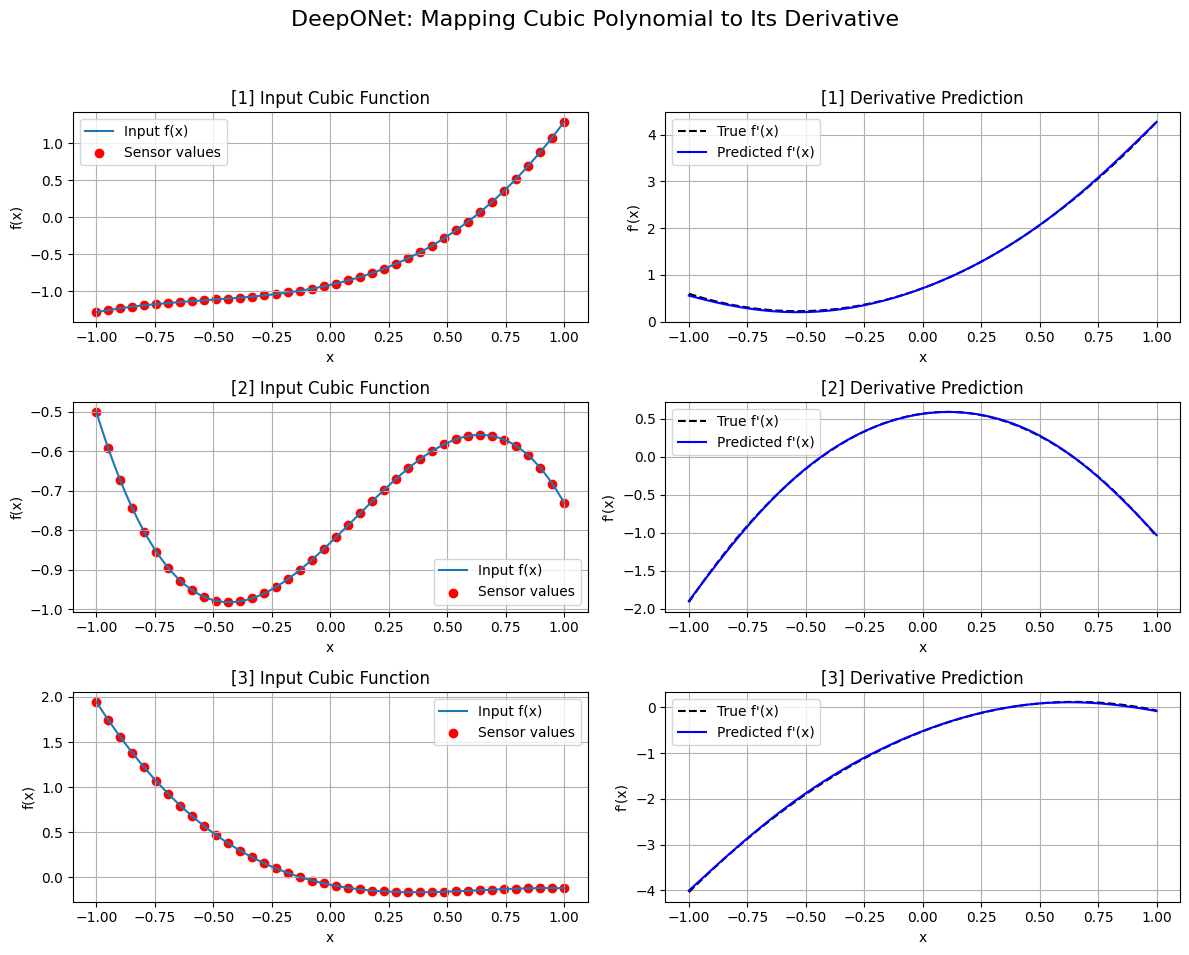

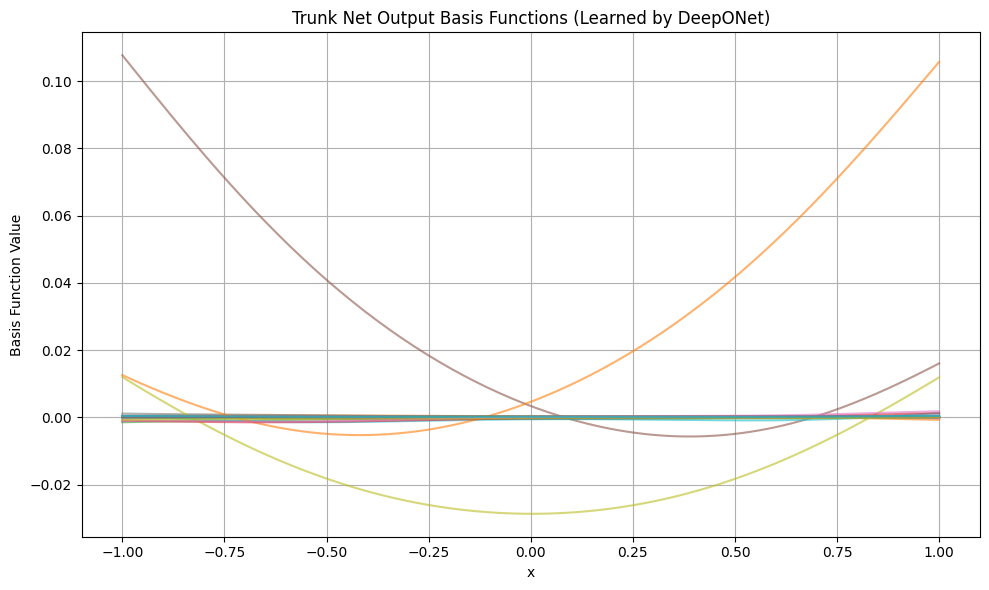

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

# some hyperparmeters for the problem
l1_lambda = 1e-4
input_range = [-1,1]
scale = 1
sensor_size = 40

# Sensor points (fixed for branch input)
sensor_x = torch.linspace(input_range[0], input_range[1], sensor_size)  # e.g., 20 equidistant points

# Trunk input points (evaluation x)
def sample_trunk_points(n_points):
    # return torch.linspace(input_range[0], input_range[1], n_points).view(-1,1)
    return (input_range[1] - input_range[0]) * torch.rand(n_points, 1) + input_range[0]

# Generate a batch of cubic polynomials and their derivatives
def generate_batch(batch_size, n_trunk_points):
    a = torch.rand(batch_size, 1) * 2 - 1
    b = torch.rand(batch_size, 1) * 2 - 1
    c = torch.rand(batch_size, 1) * 2 - 1
    d = torch.rand(batch_size, 1) * 2 - 1
    a, b, c, d = a * scale, b * scale, c * scale, d * scale


    f_values = a * sensor_x**3 + b * sensor_x**2 + c * sensor_x + d  # [B, S]

    x = sample_trunk_points(n_trunk_points)  # [T, 1]

    # True derivative values
    y = 3 * a * x.T**2 + 2 * b * x.T + c  # [B, T]
    return f_values, x, y

# simple MLP calss
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# DeepONet model
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net

    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)  # [batch, d]
        t = self.trunk_net(trunk_input)    # [batch, d]
        out = torch.matmul(b, t.T)         # scalar output
        return out

# Define DeepONet
branch_net = MLP(input_dim=sensor_size, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh)
trunk_net = MLP(input_dim=1, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh)
model = DeepONet(branch_net=branch_net, trunk_net=trunk_net)

# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(40000):
    model.train()
    branch_input, trunk_input, target = generate_batch(batch_size=64, n_trunk_points=100)
    pred = model(branch_input, trunk_input)
    loss = loss_fn(pred, target)
    trunk_output = model.trunk_net(trunk_input)
    l1_reg = l1_lambda * torch.norm(trunk_output, p=1)
    loss  += l1_reg


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

model.eval()
# l2 relative error over large batch
with torch.no_grad():
    n_test = 1000
    branch_input, trunk_input, y_true = generate_batch(batch_size=n_test, n_trunk_points=100)
    y_pred = model(branch_input, trunk_input)
    error = torch.norm(y_pred - y_true, dim=1)
    denom = torch.norm(y_true, dim=1)
    rel_error = (error / denom).mean()
    print(f"\nAverage L2 Relative Error over {n_test} test examples: {rel_error:.6f}")

# plot results
x_dense = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1)  # [200, 1]

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("DeepONet: Mapping Cubic Polynomial to Its Derivative", fontsize=16)

for i in range(3):
    # Random cubic coefficients
    a = 2*torch.rand(1).item()-1
    b = 2*torch.rand(1).item()-1
    c = 2*torch.rand(1).item()-1
    d = 2*torch.rand(1).item()-1

    # Compute input (function values at sensor points)
    f_sensor = a * sensor_x**3 + b * sensor_x**2 + c * sensor_x + d  # [S]
    f_dense = a * x_dense.squeeze()**3 + b * x_dense.squeeze()**2 + c * x_dense.squeeze() + d  # [200]
    df_true = 3*a*x_dense.squeeze()**2 + 2*b*x_dense.squeeze() + c  # [200]

    # Prepare DeepONet input: branch_input should be [B, S], we simulate batch_size = 1
    branch_input = f_sensor.unsqueeze(0)  # [1, S] as branch input for a single batch

    # Compute predictions for the dense x values
    with torch.no_grad():
        df_pred = model(branch_input, x_dense).squeeze()  # [200]

    # Plot function input (cubic polynomial)
    axs[i, 0].plot(x_dense.squeeze(), f_dense, label="Input f(x)")  # Dense f(x)
    axs[i, 0].scatter(sensor_x, f_sensor, color="red", label="Sensor values")  # Sensor points
    axs[i, 0].set_title(f"[{i+1}] Input Cubic Function")
    axs[i, 0].set_xlabel("x")
    axs[i, 0].set_ylabel("f(x)")
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Plot true vs predicted derivative
    axs[i, 1].plot(x_dense.squeeze(), df_true, 'k--', label="True f'(x)")  # True derivative
    axs[i, 1].plot(x_dense.squeeze(), df_pred, 'b-', label="Predicted f'(x)")  # Predicted derivative
    axs[i, 1].set_title(f"[{i+1}] Derivative Prediction")
    axs[i, 1].set_xlabel("x")
    axs[i, 1].set_ylabel("f'(x)")
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




# ---- Visualize trunk net basis functions over the domain ----
x_basis = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1)  # [200, 1]

with torch.no_grad():
    trunk_out = model.trunk_net(x_basis)  # [200, hidden_dim]
    trunk_out_np = trunk_out.numpy()

plt.figure(figsize=(10, 6))
for i in range(trunk_out_np.shape[1]):
    plt.plot(x_basis.squeeze(), trunk_out_np[:, i], label=f"Basis {i+1}", alpha=0.6)

plt.title("Trunk Net Output Basis Functions (Learned by DeepONet)")
plt.xlabel("x")
plt.ylabel("Basis Function Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## Two-stage DeepSet DeepONet

--- Defining Stage 1 Model (DeepSet Branch, Target: Quadratic Functions f(y)) ---
--- Starting Stage 1 Training ---
Stage 1 - Epoch 0, Loss: 0.437117
Stage 1 - Epoch 1000, Loss: 0.004561
Stage 1 - Epoch 2000, Loss: 0.003223
Stage 1 - Epoch 3000, Loss: 0.002083
Stage 1 - Epoch 4000, Loss: 0.002210
Stage 1 - Epoch 5000, Loss: 0.002896
Stage 1 - Epoch 6000, Loss: 0.001313
Stage 1 - Epoch 7000, Loss: 0.001483
Stage 1 - Epoch 8000, Loss: 0.001497
Stage 1 - Epoch 9000, Loss: 0.000972
Stage 1 - Epoch 10000, Loss: 0.000967
Stage 1 - Epoch 11000, Loss: 0.001059
Stage 1 - Epoch 12000, Loss: 0.000984
Stage 1 - Epoch 13000, Loss: 0.000921
Stage 1 - Epoch 14000, Loss: 0.000686
Stage 1 - Epoch 15000, Loss: 0.000744
Stage 1 - Epoch 16000, Loss: 0.000701
Stage 1 - Epoch 17000, Loss: 0.000875
Stage 1 - Epoch 18000, Loss: 0.000673
Stage 1 - Epoch 19000, Loss: 0.000676

--- Trunk network (trunk_net) frozen ---

--- Defining Stage 2 Model (MLP Branch, Target: Derivatives of Cubics g'(y), Fixed Quadratic T

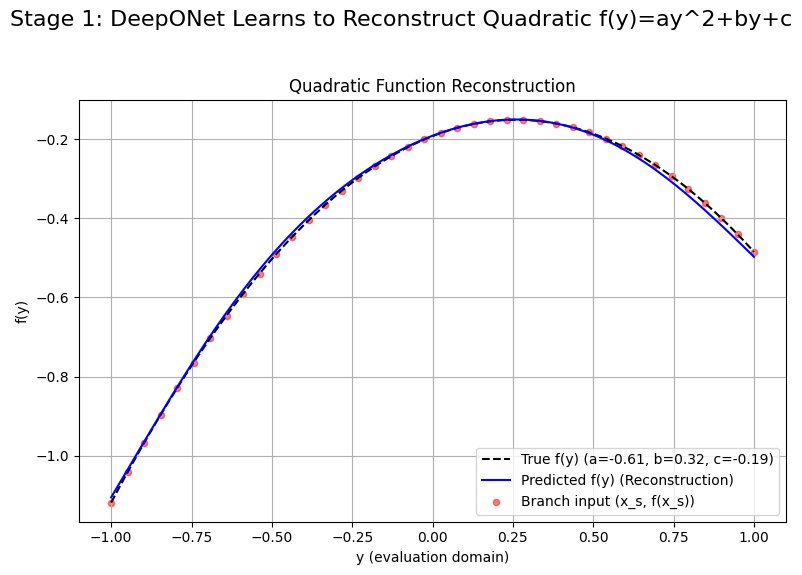


--- Plotting Stage 2 Example (Derivative of a random cubic g'(y)) ---


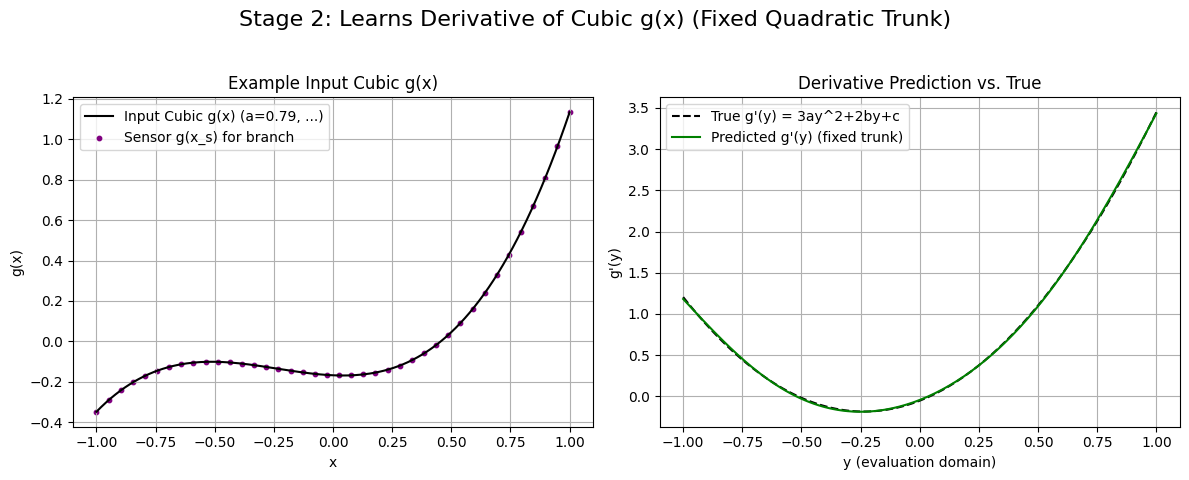


--- Plotting Fixed Trunk Basis Functions (Learned in Stage 1 for representing quadratics) ---


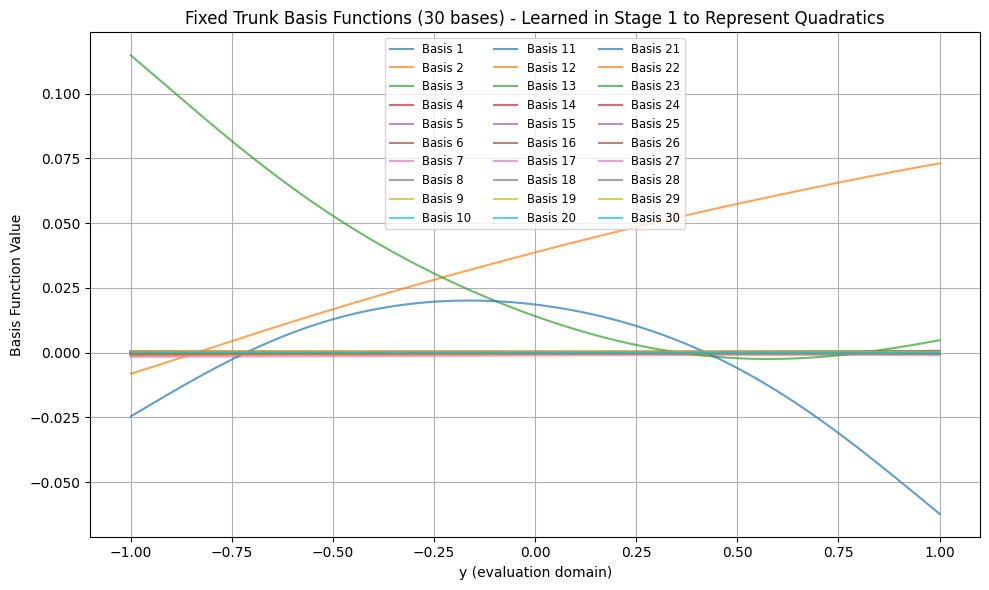


Stage 1: Average L2 Relative Error for reconstructing quadratics over ~500 examples: 0.020362
Stage 2: Average L2 Relative Error for derivatives of cubics (fixed quadratic trunk) over ~500 examples: 0.005781


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

# Hyperparameters
l1_lambda = 1e-4 # L1 regularization for trunk in Stage 1
input_range = [-1, 1]
scale = 1.0 # Scale for polynomial coefficients
sensor_size = 40 # Number of (x, f(x)) pairs for DeepSet branch / sensor values for MLP branch

# Sensor x-coordinates (fixed for branch input)
sensor_x_coords = torch.linspace(input_range[0], input_range[1], sensor_size)

# Trunk input points (evaluation points y)
def sample_trunk_points(n_points):
    return torch.linspace(input_range[0], input_range[1], n_points).view(-1, 1)

# --- Stage 1: Learn trunk basis for representing f(x)=ax^2+bx+c ---
# DeepONet learns to output f(y) = ay^2+by+c
def generate_batch_stage1(batch_size, n_trunk_points):
    # Random coefficients for quadratic functions f(x) = ax^2 + bx + c
    a_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    b_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    c_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale

    # Branch input: f(x_s) values at sensor_x_coords
    f_values_at_sensors = a_quad * sensor_x_coords**2 + b_quad * sensor_x_coords + c_quad

    sensor_x_coords_batch = sensor_x_coords.unsqueeze(0).repeat(batch_size, 1).unsqueeze(2)
    f_values_batch = f_values_at_sensors.unsqueeze(2)
    branch_input_deepset = torch.cat((sensor_x_coords_batch, f_values_batch), dim=2)

    y_trunk = sample_trunk_points(n_trunk_points)  # [T, 1]

    # Target: f(y) = ay^2 + by + c (the quadratic function itself)
    target_stage1 = a_quad * y_trunk.T**2 + b_quad * y_trunk.T + c_quad

    return branch_input_deepset, y_trunk, target_stage1, (a_quad, b_quad, c_quad)

# --- Stage 2: Learn MLP branch for derivatives of g(x)=ax^3+bx^2+cx+d, using fixed (quadratic) trunk ---
# DeepONet learns to output g'(y) = 3ay^2+2by+c
def generate_batch_stage2(batch_size, n_trunk_points):
    # Random coefficients for cubic functions g(x) = ax^3 + bx^2 + cx + d
    a_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    b_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    c_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    d_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale

    # Branch input: g(x_s) values at sensor_x_coords
    g_values_at_sensors = a_cub * sensor_x_coords**3 + b_cub * sensor_x_coords**2 + \
                          c_cub * sensor_x_coords + d_cub
    branch_input_mlp = g_values_at_sensors # Shape [B, S]

    y_trunk = sample_trunk_points(n_trunk_points)  # [T, 1]

    # Target: g'(y) = 3ay^2 + 2by + c (derivative of the cubic)
    target_stage2 = 3 * a_cub * y_trunk.T**2 + 2 * b_cub * y_trunk.T + c_cub

    return branch_input_mlp, y_trunk, target_stage2, (a_cub, b_cub, c_cub, d_cub)


# MLP class (generic)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# DeepSet Branch Network
class DeepSetBranch(nn.Module):
    def __init__(self, element_dim, phi_hidden_dims, phi_output_dim,
                 rho_hidden_dims, branch_output_dim, activation=nn.Tanh):
        super().__init__()
        self.phi = MLP(element_dim, phi_hidden_dims, phi_output_dim, activation)
        self.rho = MLP(phi_output_dim, rho_hidden_dims, branch_output_dim, activation)
    def forward(self, set_elements):
        phi_out = self.phi(set_elements)
        sum_phi_out = torch.sum(phi_out, dim=1)
        branch_embedding = self.rho(sum_phi_out)
        return branch_embedding

# DeepONet model
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)
        t = self.trunk_net(trunk_input)
        out = torch.matmul(b, t.T)
        return out

# --- Network Hyperparameters ---
element_input_dim_ds = 2
phi_hidden_dims_ds = [64, 128]
phi_output_dim_ds = 128
rho_hidden_dims_ds = [128, 64]

mlp_branch_input_dim = sensor_size
mlp_branch_hidden_dims = [128, 64] # Can be tuned

branch_and_trunk_output_dim = 30 # P, number of basis functions

# --- Stage 1: Define and Train ---
print("--- Defining Stage 1 Model (DeepSet Branch, Target: Quadratic Functions f(y)) ---")
branch_s1_deepset = DeepSetBranch(
    element_dim=element_input_dim_ds,
    phi_hidden_dims=phi_hidden_dims_ds,
    phi_output_dim=phi_output_dim_ds,
    rho_hidden_dims=rho_hidden_dims_ds,
    branch_output_dim=branch_and_trunk_output_dim,
    activation=nn.Tanh
)
trunk_net = MLP(input_dim=1, hidden_dims=[64, 64, 64], output_dim=branch_and_trunk_output_dim, activation=nn.Tanh) # Added a layer to trunk
model_s1 = DeepONet(branch_net=branch_s1_deepset, trunk_net=trunk_net)

loss_fn_s1 = nn.MSELoss()
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=1e-3)
epochs_s1 = 20000

print("--- Starting Stage 1 Training ---")
for epoch in range(epochs_s1):
    model_s1.train()
    branch_in, trunk_in, target, _ = generate_batch_stage1(batch_size=64, n_trunk_points=50)

    pred = model_s1(branch_in, trunk_in)
    loss = loss_fn_s1(pred, target)

    trunk_output_for_reg = model_s1.trunk_net(trunk_in)
    l1_reg = l1_lambda * torch.norm(trunk_output_for_reg, p=1)
    loss += l1_reg

    optimizer_s1.zero_grad()
    loss.backward()
    optimizer_s1.step()

    if epoch % 1000 == 0:
        print(f"Stage 1 - Epoch {epoch}, Loss: {loss.item():.6f}")

for param in trunk_net.parameters():
    param.requires_grad = False
print("\n--- Trunk network (trunk_net) frozen ---")


# --- Stage 2: Define and Train ---
print("\n--- Defining Stage 2 Model (MLP Branch, Target: Derivatives of Cubics g'(y), Fixed Quadratic Trunk) ---")
branch_s2_mlp = MLP(
    input_dim=mlp_branch_input_dim,
    hidden_dims=mlp_branch_hidden_dims,
    output_dim=branch_and_trunk_output_dim,
    activation=nn.ReLU
)
model_s2 = DeepONet(branch_net=branch_s2_mlp, trunk_net=trunk_net)

loss_fn_s2 = nn.MSELoss()
optimizer_s2 = optim.Adam(model_s2.branch_net.parameters(), lr=5e-4)
epochs_s2 = 20000

print("--- Starting Stage 2 Training ---")
for epoch in range(epochs_s2):
    model_s2.branch_net.train()
    model_s2.trunk_net.eval()

    branch_in, trunk_in, target, _ = generate_batch_stage2(batch_size=64, n_trunk_points=50)

    pred = model_s2(branch_in, trunk_in)
    loss = loss_fn_s2(pred, target)

    optimizer_s2.zero_grad()
    loss.backward()
    optimizer_s2.step()

    if epoch % 1000 == 0:
        print(f"Stage 2 - Epoch {epoch}, Loss: {loss.item():.6f}")


# --- Evaluation and Plotting ---
x_dense_plot = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1)

# Plotting for Stage 1 results (Reconstructing a random quadratic)
print("\n--- Plotting Stage 1 Example (Reconstructing a random quadratic f(y)) ---")
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig1.suptitle("Stage 1: DeepONet Learns to Reconstruct Quadratic f(y)=ay^2+by+c", fontsize=16)

branch_in_plot_s1, _, target_plot_s1, (a_q, b_q, c_q) = generate_batch_stage1(batch_size=1, n_trunk_points=x_dense_plot.shape[0])
# target_plot_s1 is already f(y)

with torch.no_grad():
    model_s1.eval()
    pred_plot_s1 = model_s1(branch_in_plot_s1, x_dense_plot).squeeze()

ax1.plot(x_dense_plot.numpy(), target_plot_s1.squeeze().numpy(), 'k--', label=f'True f(y) (a={a_q.item():.2f}, b={b_q.item():.2f}, c={c_q.item():.2f})')
ax1.plot(x_dense_plot.numpy(), pred_plot_s1.numpy(), 'b-', label="Predicted f(y) (Reconstruction)")
# For context, show sensor inputs for branch
sensor_vals_plot_s1 = a_q.item() * sensor_x_coords**2 + b_q.item() * sensor_x_coords + c_q.item()
ax1.scatter(sensor_x_coords.numpy(), sensor_vals_plot_s1.numpy(), color='red', marker='o', label='Branch input (x_s, f(x_s))', alpha=0.5, s=20)
ax1.set_title("Quadratic Function Reconstruction")
ax1.set_xlabel("y (evaluation domain)")
ax1.set_ylabel("f(y)")
ax1.legend()
ax1.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Plotting for Stage 2 results (Derivative of a random cubic)
print("\n--- Plotting Stage 2 Example (Derivative of a random cubic g'(y)) ---")
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5)) # Kept two subplots for g(x) and g'(y)
fig2.suptitle("Stage 2: Learns Derivative of Cubic g(x) (Fixed Quadratic Trunk)", fontsize=16)

branch_in_plot_s2, _, target_plot_s2, (a_c,b_c,c_c,d_c) = generate_batch_stage2(batch_size=1, n_trunk_points=x_dense_plot.shape[0])
g_x_plot_s2 = a_c.item() * x_dense_plot.squeeze()**3 + b_c.item() * x_dense_plot.squeeze()**2 + \
              c_c.item() * x_dense_plot.squeeze() + d_c.item()
# target_plot_s2 is g'(y)

with torch.no_grad():
    model_s2.eval()
    pred_plot_s2 = model_s2(branch_in_plot_s2, x_dense_plot).squeeze()

axs2[0].plot(x_dense_plot.numpy(), g_x_plot_s2.numpy(), 'k-', label=f'Input Cubic g(x) (a={a_c.item():.2f}, ...)')
sensor_vals_plot_s2 = a_c.item() * sensor_x_coords**3 + b_c.item() * sensor_x_coords**2 + \
                      c_c.item() * sensor_x_coords + d_c.item()
axs2[0].scatter(sensor_x_coords.numpy(), sensor_vals_plot_s2.numpy(), color='purple', label='Sensor g(x_s) for branch', s=10)
axs2[0].set_title("Example Input Cubic g(x)")
axs2[0].set_xlabel("x")
axs2[0].set_ylabel("g(x)")
axs2[0].legend()
axs2[0].grid(True)

axs2[1].plot(x_dense_plot.numpy(), target_plot_s2.squeeze().numpy(), 'k--', label="True g'(y) = 3ay^2+2by+c")
axs2[1].plot(x_dense_plot.numpy(), pred_plot_s2.numpy(), 'g-', label="Predicted g'(y) (fixed trunk)")
axs2[1].set_title("Derivative Prediction vs. True")
axs2[1].set_xlabel("y (evaluation domain)")
axs2[1].set_ylabel("g'(y)")
axs2[1].legend()
axs2[1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Visualize trunk net basis functions
print("\n--- Plotting Fixed Trunk Basis Functions (Learned in Stage 1 for representing quadratics) ---")
with torch.no_grad():
    trunk_net.eval()
    trunk_out_fixed = trunk_net(x_dense_plot)
    trunk_out_np_fixed = trunk_out_fixed.numpy()

plt.figure(figsize=(10, 6))
for i in range(trunk_out_np_fixed.shape[1]):
    plt.plot(x_dense_plot.squeeze().numpy(), trunk_out_np_fixed[:, i], label=f"Basis {i+1}", alpha=0.7)
plt.title(f"Fixed Trunk Basis Functions ({branch_and_trunk_output_dim} bases) - Learned in Stage 1 to Represent Quadratics")
plt.xlabel("y (evaluation domain)")
plt.ylabel("Basis Function Value")
plt.legend(fontsize='small', ncol=max(1, branch_and_trunk_output_dim // 10))
plt.grid(True)
plt.tight_layout()
plt.show()

# Final L2 relative error for Stage 1
with torch.no_grad():
    model_s1.eval()
    n_test = 500
    errors_s1 = []
    for _ in range(n_test // 64 +1):
        branch_input_test, trunk_input_test, y_true_test, _ = generate_batch_stage1(batch_size=64, n_trunk_points=100)
        y_pred_test = model_s1(branch_input_test, trunk_input_test)
        error_s1_batch = torch.norm(y_pred_test - y_true_test, dim=1) / (torch.norm(y_true_test, dim=1) + 1e-8)
        errors_s1.extend(error_s1_batch.tolist())
    rel_error_s1 = np.mean(errors_s1)
    print(f"\nStage 1: Average L2 Relative Error for reconstructing quadratics over ~{n_test} examples: {rel_error_s1:.6f}")

# Final L2 relative error for Stage 2
with torch.no_grad():
    model_s2.eval()
    n_test = 500
    errors_s2 = []
    for _ in range(n_test // 64 + 1):
        branch_input_test, trunk_input_test, y_true_test, _ = generate_batch_stage2(batch_size=64, n_trunk_points=100)
        y_pred_test = model_s2(branch_input_test, trunk_input_test)
        error_s2_batch = torch.norm(y_pred_test - y_true_test, dim=1) / (torch.norm(y_true_test, dim=1) + 1e-8)
        errors_s2.extend(error_s2_batch.tolist())
    rel_error_s2 = np.mean(errors_s2)
    print(f"Stage 2: Average L2 Relative Error for derivatives of cubics (fixed quadratic trunk) over ~{n_test} examples: {rel_error_s2:.6f}")


--- Checking Orthogonality of Fixed Trunk Basis Functions ---


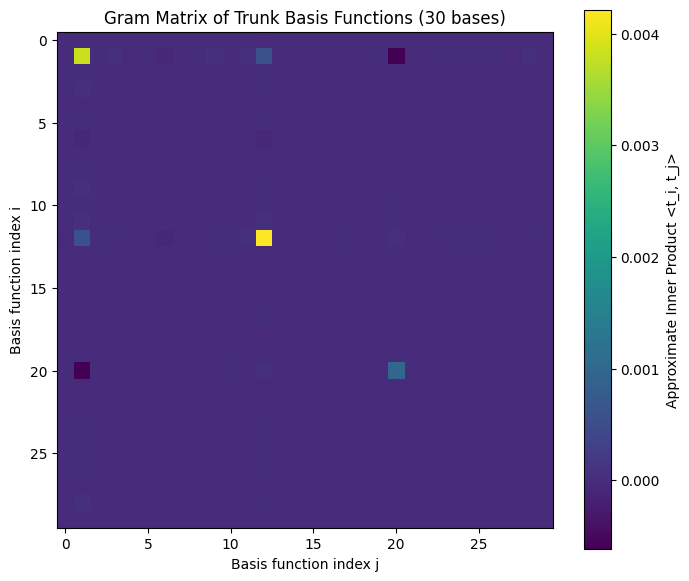

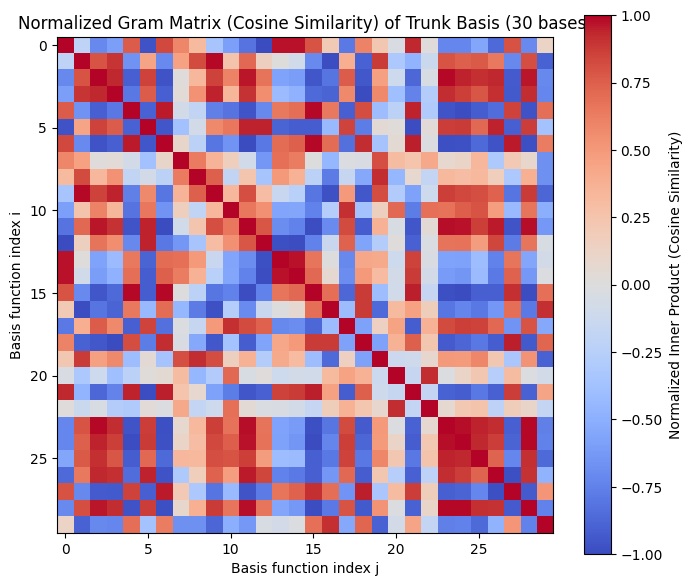

Orthogonality Metric (Sum(|off-diag|) / Sum(|diag|)): 0.4929
Sum of absolute diagonal elements: 0.0090
Sum of absolute off-diagonal elements: 0.0044
Deviation from Identity (for Normalized Gram Matrix): 530.4259


In [ ]:
# (Keep all the previous code for model definition, training, and plotting)

# --- Add this section after plotting the fixed trunk basis functions ---

print("\n--- Checking Orthogonality of Fixed Trunk Basis Functions ---")
# The basis functions are in trunk_out_np_fixed: [num_points, num_bases]
# x_dense_plot_numpy = x_dense_plot.squeeze().numpy()
num_points = trunk_out_np_fixed.shape[0]
num_bases = trunk_out_np_fixed.shape[1]

# Approximate inner products to form the Gram matrix
# We'll use a simple sum as an approximation of the integral, assuming equal spacing (dy is constant)
# For a more accurate integral, you could use scipy.integrate.simps or trapz
gram_matrix = np.zeros((num_bases, num_bases))

# Calculate dy (spacing between points) for a more formal inner product
# dy = x_dense_plot_numpy[1] - x_dense_plot_numpy[0] # if x_dense_plot is numpy
dy = (x_dense_plot[1,0] - x_dense_plot[0,0]).item()


for i in range(num_bases):
    for j in range(i, num_bases): # Compute only upper triangle, it's symmetric
        # Inner product: integral of t_i(y) * t_j(y) dy
        # Approximate with sum: sum(t_i[k] * t_j[k] * dy for k in range(num_points))
        inner_product = np.sum(trunk_out_np_fixed[:, i] * trunk_out_np_fixed[:, j]) * dy
        gram_matrix[i, j] = inner_product
        if i != j:
            gram_matrix[j, i] = inner_product # Symmetric

plt.figure(figsize=(8, 7))
plt.imshow(gram_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Approximate Inner Product <t_i, t_j>')
plt.title(f'Gram Matrix of Trunk Basis Functions ({num_bases} bases)')
plt.xlabel('Basis function index j')
plt.ylabel('Basis function index i')
plt.grid(False)
plt.show()

# Optional: Normalize the Gram matrix by the norms of basis functions
# This gives the cosine similarity matrix if basis vectors are not normalized.
# If basis vectors were L2 normalized, this would be closer to identity for an orthonormal basis.
normalized_gram_matrix = np.zeros((num_bases, num_bases))
norms_squared = np.diag(gram_matrix) # These are <t_i, t_i> = ||t_i||^2
norms = np.sqrt(norms_squared)

for i in range(num_bases):
    for j in range(num_bases):
        if norms[i] > 1e-9 and norms[j] > 1e-9: # Avoid division by zero for zero-norm basis
             normalized_gram_matrix[i,j] = gram_matrix[i,j] / (norms[i] * norms[j])
        else:
             normalized_gram_matrix[i,j] = gram_matrix[i,j] # keep original if norm is zero

plt.figure(figsize=(8, 7))
plt.imshow(normalized_gram_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar(label='Normalized Inner Product (Cosine Similarity)')
plt.title(f'Normalized Gram Matrix (Cosine Similarity) of Trunk Basis ({num_bases} bases)')
plt.xlabel('Basis function index j')
plt.ylabel('Basis function index i')
plt.grid(False)
plt.show()

# Quantify non-orthogonality (sum of absolute off-diagonal elements)
# For the original Gram matrix
off_diagonal_sum_abs = np.sum(np.abs(gram_matrix - np.diag(np.diag(gram_matrix))))
diagonal_sum_abs = np.sum(np.abs(np.diag(gram_matrix)))
orthogonality_metric = off_diagonal_sum_abs / diagonal_sum_abs if diagonal_sum_abs > 1e-9 else float('inf')
print(f"Orthogonality Metric (Sum(|off-diag|) / Sum(|diag|)): {orthogonality_metric:.4f}")
print(f"Sum of absolute diagonal elements: {diagonal_sum_abs:.4f}")
print(f"Sum of absolute off-diagonal elements: {off_diagonal_sum_abs:.4f}")

# For the normalized Gram matrix (closer to identity for orthonormal)
identity_matrix = np.eye(num_bases)
deviation_from_identity = np.sum(np.abs(normalized_gram_matrix - identity_matrix))
print(f"Deviation from Identity (for Normalized Gram Matrix): {deviation_from_identity:.4f}")
# A perfectly orthonormal basis would have deviation_from_identity = 0 (for off-diagonals)
# and diagonal elements = 1. The sum of absolute differences from identity captures this.

### Independent MLPs

--- Defining Stage 1 Model ---
--- Starting Stage 1 Training ---
Stage 1 - Epoch 0, Loss: 0.425258
Stage 1 - Epoch 1000, Loss: 0.002385
Stage 1 - Epoch 2000, Loss: 0.001783
Stage 1 - Epoch 3000, Loss: 0.000850
Stage 1 - Epoch 4000, Loss: 0.001208
Stage 1 - Epoch 5000, Loss: 0.000578
Stage 1 - Epoch 6000, Loss: 0.002288
Stage 1 - Epoch 7000, Loss: 0.000360
Stage 1 - Epoch 8000, Loss: 0.000349
Stage 1 - Epoch 9000, Loss: 0.000384
Stage 1 - Epoch 10000, Loss: 0.000868
Stage 1 - Epoch 11000, Loss: 0.000318
Stage 1 - Epoch 12000, Loss: 0.000511
Stage 1 - Epoch 13000, Loss: 0.000381
Stage 1 - Epoch 14000, Loss: 0.000384
Stage 1 - Epoch 15000, Loss: 0.000275
Stage 1 - Epoch 16000, Loss: 0.000310
Stage 1 - Epoch 17000, Loss: 0.001068
Stage 1 - Epoch 18000, Loss: 0.000324
Stage 1 - Epoch 19000, Loss: 0.000205
Stage 1 - Epoch 20000, Loss: 0.001229
Stage 1 - Epoch 21000, Loss: 0.000209
Stage 1 - Epoch 22000, Loss: 0.000692
Stage 1 - Epoch 23000, Loss: 0.000259
Stage 1 - Epoch 24000, Loss: 0.00038

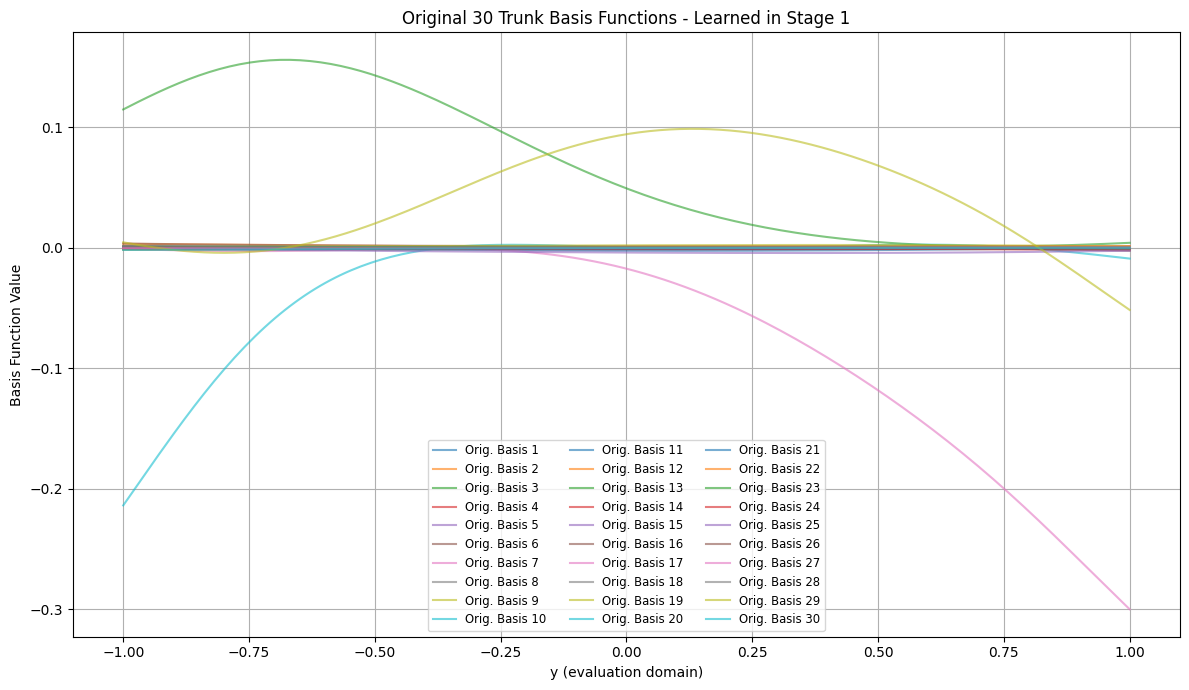

--- Plotting Gram Matrices for Original (All) Trunk Bases ---


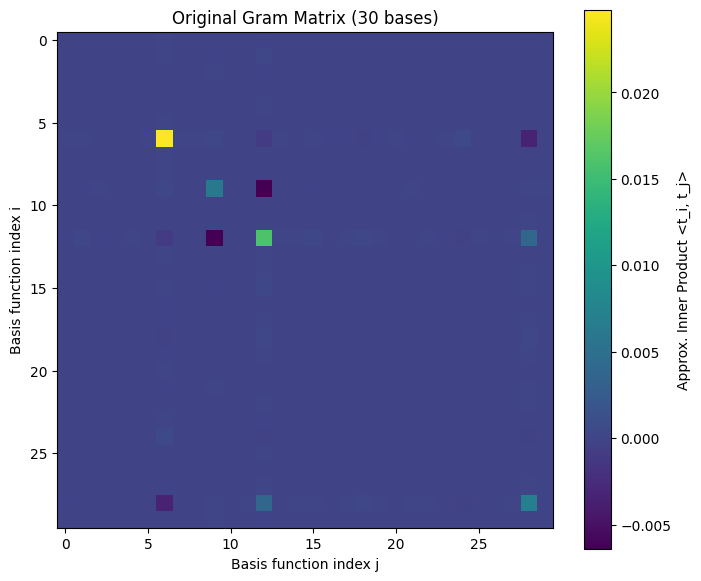

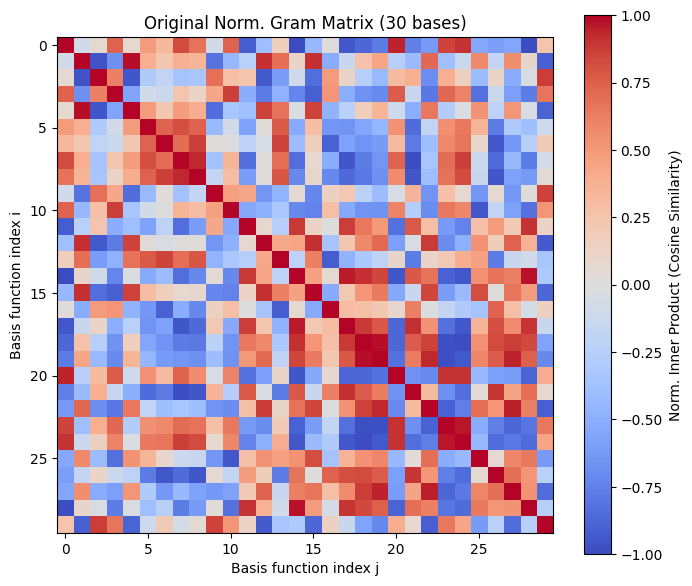

L2 norms of original basis functions: [0.00214162 0.00210804 0.0013399  0.00074503 0.000895   0.00040676
 0.15733385 0.00117893 0.00046324 0.07848333 0.00065666 0.00061737
 0.12679704 0.00100975 0.00086759 0.00241232 0.00063746 0.0012215
 0.00271747 0.00135193 0.00112382 0.00153352 0.00087516 0.00122034
 0.00451626 0.00054797 0.00038778 0.00110657 0.08396918 0.00095853]
Using L2 norm pruning threshold: 0.01
Number of original bases: 30
Number of surviving bases after pruning: 4
Indices of surviving bases: [ 6  9 12 28]

--- Plotting Gram Matrices for Surviving (4) Trunk Bases ---


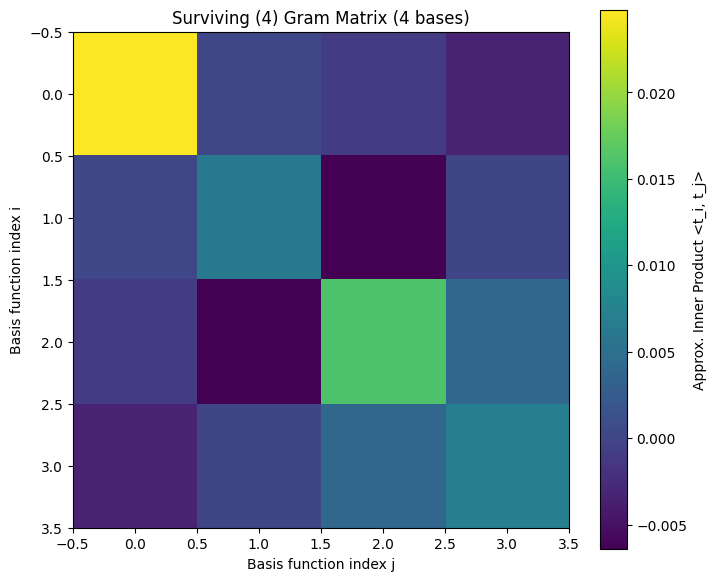

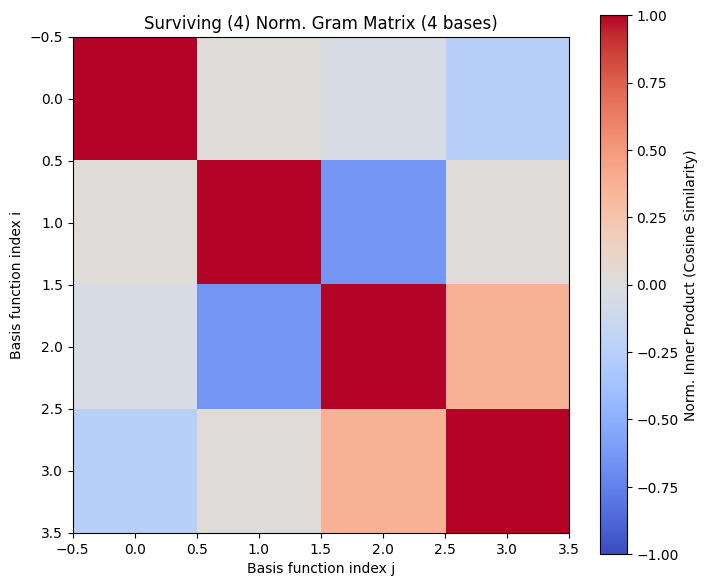


--- Defining Stage 2 Model (MLP Branch for 4 surviving bases) ---
--- Starting Stage 2 Training (with pruned basis) ---
Stage 2 (Pruned) - Epoch 0, Loss: 1.479151
Stage 2 (Pruned) - Epoch 1000, Loss: 0.001395
Stage 2 (Pruned) - Epoch 2000, Loss: 0.000482
Stage 2 (Pruned) - Epoch 3000, Loss: 0.000296
Stage 2 (Pruned) - Epoch 4000, Loss: 0.000201
Stage 2 (Pruned) - Epoch 5000, Loss: 0.000173
Stage 2 (Pruned) - Epoch 6000, Loss: 0.000070
Stage 2 (Pruned) - Epoch 7000, Loss: 0.000054
Stage 2 (Pruned) - Epoch 8000, Loss: 0.000031
Stage 2 (Pruned) - Epoch 9000, Loss: 0.000039
Stage 2 (Pruned) - Epoch 10000, Loss: 0.000032
Stage 2 (Pruned) - Epoch 11000, Loss: 0.000028
Stage 2 (Pruned) - Epoch 12000, Loss: 0.000055
Stage 2 (Pruned) - Epoch 13000, Loss: 0.000031
Stage 2 (Pruned) - Epoch 14000, Loss: 0.000025
Stage 2 (Pruned) - Epoch 15000, Loss: 0.000066
Stage 2 (Pruned) - Epoch 16000, Loss: 0.000029
Stage 2 (Pruned) - Epoch 17000, Loss: 0.000025
Stage 2 (Pruned) - Epoch 18000, Loss: 0.000048

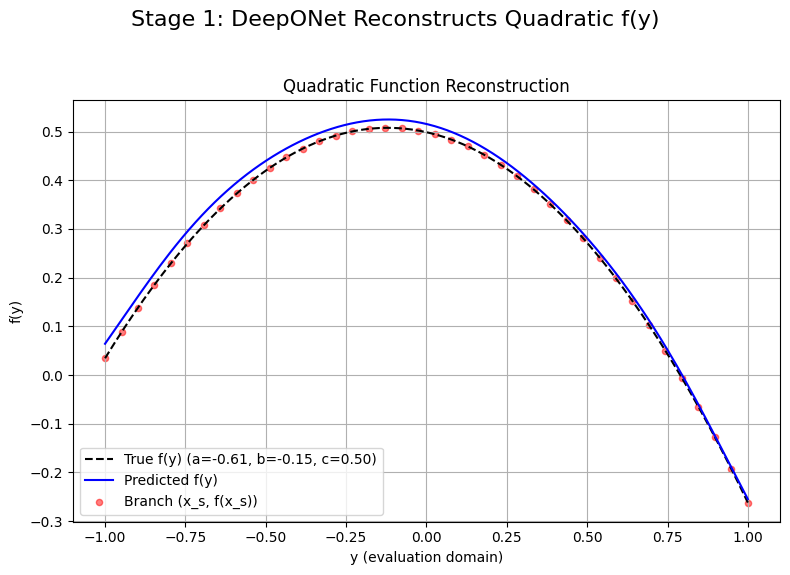


--- Plotting Stage 2 Example (Pruned Basis) ---


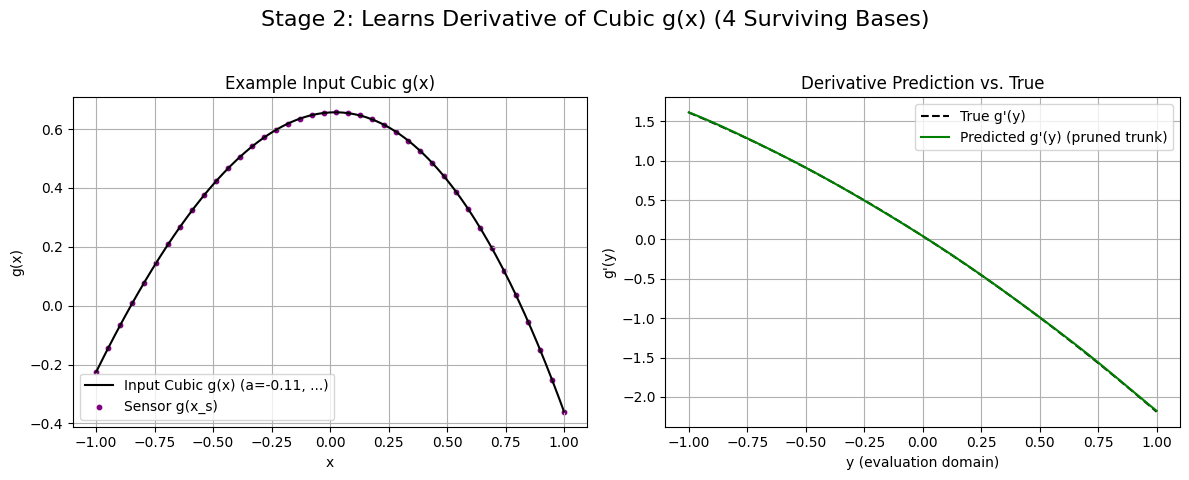


Stage 1: Avg L2 Rel Error (30 bases) over ~500 examples: 0.033361
Stage 2 (Pruned): Avg L2 Rel Error (4 surv. bases) over ~500 examples: 0.004411


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

# Hyperparameters
l1_lambda = 1e-5
input_range = [-1, 1]
scale = 1.0
sensor_size = 40
num_original_bases = 30

# Sensor x-coordinates
sensor_x_coords = torch.linspace(input_range[0], input_range[1], sensor_size)

# Trunk input points
def sample_trunk_points(n_points):
    return torch.linspace(input_range[0], input_range[1], n_points).view(-1, 1)

# --- Stage 1: Learn trunk basis for representing f(x)=ax^2+bx+c ---
def generate_batch_stage1(batch_size, n_trunk_points):
    a_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    b_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    c_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    f_values_at_sensors = a_quad * sensor_x_coords**2 + b_quad * sensor_x_coords + c_quad
    sensor_x_coords_batch = sensor_x_coords.unsqueeze(0).repeat(batch_size, 1).unsqueeze(2)
    f_values_batch = f_values_at_sensors.unsqueeze(2)
    branch_input_deepset = torch.cat((sensor_x_coords_batch, f_values_batch), dim=2)
    y_trunk = sample_trunk_points(n_trunk_points)
    target_stage1 = a_quad * y_trunk.T**2 + b_quad * y_trunk.T + c_quad
    return branch_input_deepset, y_trunk, target_stage1, (a_quad, b_quad, c_quad)

# --- Stage 2: Learn MLP branch for derivatives of g(x)=ax^3+bx^2+cx+d ---
def generate_batch_stage2(batch_size, n_trunk_points):
    a_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    b_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    c_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    d_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    g_values_at_sensors = a_cub * sensor_x_coords**3 + b_cub * sensor_x_coords**2 + \
                          c_cub * sensor_x_coords + d_cub
    branch_input_mlp = g_values_at_sensors
    y_trunk = sample_trunk_points(n_trunk_points)
    target_stage2 = 3 * a_cub * y_trunk.T**2 + 2 * b_cub * y_trunk.T + c_cub
    return branch_input_mlp, y_trunk, target_stage2, (a_cub, b_cub, c_cub, d_cub)

# MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# DeepSet Branch Network
class DeepSetBranch(nn.Module):
    def __init__(self, element_dim, phi_hidden_dims, phi_output_dim,
                 rho_hidden_dims, branch_output_dim, activation=nn.Tanh):
        super().__init__()
        self.phi = MLP(element_dim, phi_hidden_dims, phi_output_dim, activation)
        self.rho = MLP(phi_output_dim, rho_hidden_dims, branch_output_dim, activation)
    def forward(self, set_elements):
        phi_out = self.phi(set_elements)
        sum_phi_out = torch.sum(phi_out, dim=1)
        branch_embedding = self.rho(sum_phi_out)
        return branch_embedding

# Standard DeepONet model
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)
        t = self.trunk_net(trunk_input)
        out = torch.matmul(b, t.T)
        return out

# DeepONet for Pruned Stage 2
class PrunedDeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net, surviving_trunk_indices):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
        self.surviving_trunk_indices = surviving_trunk_indices
    def forward(self, branch_input, trunk_input):
        b_prime = self.branch_net(branch_input)
        t_all = self.trunk_net(trunk_input)
        indices_on_device = self.surviving_trunk_indices.to(t_all.device)
        t_survivors = t_all[:, indices_on_device]
        out = torch.matmul(b_prime, t_survivors.T)
        return out

# --- Network Hyperparameters ---
element_input_dim_ds = 2
phi_hidden_dims_ds = [64, 128]
phi_output_dim_ds = 128
rho_hidden_dims_ds = [128, 64]
mlp_branch_input_dim_stage2 = sensor_size
mlp_branch_hidden_dims_stage2 = [128, 64]

# --- Stage 1: Define and Train ---
print("--- Defining Stage 1 Model ---")
branch_s1_deepset = DeepSetBranch(
    element_dim=element_input_dim_ds, phi_hidden_dims=phi_hidden_dims_ds,
    phi_output_dim=phi_output_dim_ds, rho_hidden_dims=rho_hidden_dims_ds,
    branch_output_dim=num_original_bases, activation=nn.Tanh
)
trunk_net_original = MLP(input_dim=1, hidden_dims=[64, 64, 64], output_dim=num_original_bases, activation=nn.Tanh)
model_s1 = DeepONet(branch_net=branch_s1_deepset, trunk_net=trunk_net_original)
loss_fn_s1 = nn.MSELoss()
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=1e-3)
epochs_s1 = 25000
print("--- Starting Stage 1 Training ---")
for epoch in range(epochs_s1):
    model_s1.train()
    branch_in, trunk_in, target, _ = generate_batch_stage1(batch_size=64, n_trunk_points=50)
    pred = model_s1(branch_in, trunk_in)
    loss = loss_fn_s1(pred, target)
    trunk_output_for_reg = model_s1.trunk_net(trunk_in)
    l1_reg = l1_lambda * torch.norm(trunk_output_for_reg, p=1)
    loss += l1_reg
    optimizer_s1.zero_grad()
    loss.backward()
    optimizer_s1.step()
    if epoch % 1000 == 0:
        print(f"Stage 1 - Epoch {epoch}, Loss: {loss.item():.6f}")
for param in trunk_net_original.parameters():
    param.requires_grad = False
print("\n--- Original Trunk network frozen ---")

# --- Gram Matrix Plotting Function ---
def plot_gram_matrices(basis_values_np, num_bases_to_plot, dy_spacing, title_prefix=""):
    gram_matrix = np.zeros((num_bases_to_plot, num_bases_to_plot))
    for r_idx in range(num_bases_to_plot):
        for c_idx in range(r_idx, num_bases_to_plot):
            inner_prod = np.sum(basis_values_np[:, r_idx] * basis_values_np[:, c_idx]) * dy_spacing
            gram_matrix[r_idx, c_idx] = inner_prod
            if r_idx != c_idx: gram_matrix[c_idx, r_idx] = inner_prod

    plt.figure(figsize=(8, 7))
    plt.imshow(gram_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Approx. Inner Product <t_i, t_j>')
    plt.title(f'{title_prefix}Gram Matrix ({num_bases_to_plot} bases)')
    plt.xlabel('Basis function index j')
    plt.ylabel('Basis function index i')
    plt.grid(False)
    plt.show()

    normalized_gram_matrix = np.zeros((num_bases_to_plot, num_bases_to_plot))
    norms_squared = np.diag(gram_matrix)
    norms = np.sqrt(np.maximum(norms_squared, 1e-12)) # Epsilon for stability

    for r_idx in range(num_bases_to_plot):
        for c_idx in range(num_bases_to_plot):
            if norms[r_idx] > 1e-9 and norms[c_idx] > 1e-9:
                 normalized_gram_matrix[r_idx,c_idx] = gram_matrix[r_idx,c_idx] / (norms[r_idx] * norms[c_idx])
            else:
                 normalized_gram_matrix[r_idx,c_idx] = 0.0 if r_idx!=c_idx else (1.0 if norms[r_idx] > 1e-9 else 0.0)

    plt.figure(figsize=(8, 7))
    plt.imshow(normalized_gram_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
    plt.colorbar(label='Norm. Inner Product (Cosine Similarity)')
    plt.title(f'{title_prefix}Norm. Gram Matrix ({num_bases_to_plot} bases)')
    plt.xlabel('Basis function index j')
    plt.ylabel('Basis function index i')
    plt.grid(False)
    plt.show()


# --- Pruning Step & Gram Matrix Plotting (Before Pruning) ---
print("\n--- Evaluating Original Trunk Basis Functions (Before Pruning) ---")
x_dense_plot = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1)
dy_spacing = (x_dense_plot[1,0] - x_dense_plot[0,0]).item()
with torch.no_grad():
    trunk_net_original.eval()
    trunk_out_all_bases_values = trunk_net_original(x_dense_plot).numpy()

plt.figure(figsize=(12, 7))
for i in range(num_original_bases):
    plt.plot(x_dense_plot.squeeze().numpy(), trunk_out_all_bases_values[:, i], label=f"Orig. Basis {i+1}", alpha=0.6)
plt.title(f"Original {num_original_bases} Trunk Basis Functions - Learned in Stage 1")
plt.xlabel("y (evaluation domain)")
plt.ylabel("Basis Function Value")
plt.legend(fontsize='small', ncol=max(1, num_original_bases // 10))
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- Plotting Gram Matrices for Original (All) Trunk Bases ---")
plot_gram_matrices(trunk_out_all_bases_values, num_original_bases, dy_spacing, title_prefix="Original ")

# Pruning based on L2 norm
l2_norms_orig = np.zeros(num_original_bases)
for i in range(num_original_bases):
    l2_norms_orig[i] = np.sqrt(np.sum(trunk_out_all_bases_values[:, i]**2) * dy_spacing)
print("L2 norms of original basis functions:", l2_norms_orig)
pruning_threshold = 1e-2
print(f"Using L2 norm pruning threshold: {pruning_threshold}")
surviving_indices = np.where(l2_norms_orig > pruning_threshold)[0]
num_survivors = len(surviving_indices)
if num_survivors == 0:
    print("WARNING: No basis functions survived pruning! Using the one with max norm.")
    if num_original_bases > 0 and np.max(l2_norms_orig) > 0:
        surviving_indices = np.array([np.argmax(l2_norms_orig)])
        num_survivors = 1
    else:
        raise ValueError("All original basis functions have zero norm. Check Stage 1.")
print(f"Number of original bases: {num_original_bases}")
print(f"Number of surviving bases after pruning: {num_survivors}")
print(f"Indices of surviving bases: {surviving_indices}")
surviving_indices_tensor = torch.tensor(surviving_indices, dtype=torch.long)

# --- Gram Matrix Plotting (After Pruning) ---
if num_survivors > 0 and num_survivors < num_original_bases :
    print(f"\n--- Plotting Gram Matrices for Surviving ({num_survivors}) Trunk Bases ---")
    trunk_out_surviving_bases_values = trunk_out_all_bases_values[:, surviving_indices]
    plot_gram_matrices(trunk_out_surviving_bases_values, num_survivors, dy_spacing, title_prefix=f"Surviving ({num_survivors}) ")
elif num_survivors == num_original_bases:
    print("\n--- No pruning occurred, all bases survived. Gram matrices for surviving bases are same as original. ---")
else: # num_survivors is 0 (though fallback should prevent this) or some other edge case
    print("\n--- Skipping Gram matrices for surviving bases as no/all bases survived in a typical pruning scenario. ---")


# --- Stage 2: Define and Train with Pruned Basis ---
print(f"\n--- Defining Stage 2 Model (MLP Branch for {num_survivors} surviving bases) ---")
branch_s2_mlp_pruned = MLP(
    input_dim=mlp_branch_input_dim_stage2, hidden_dims=mlp_branch_hidden_dims_stage2,
    output_dim=num_survivors, activation=nn.ReLU
)
model_s2_pruned = PrunedDeepONet(
    branch_net=branch_s2_mlp_pruned, trunk_net=trunk_net_original,
    surviving_trunk_indices=surviving_indices_tensor
)
loss_fn_s2 = nn.MSELoss()
optimizer_s2 = optim.Adam(model_s2_pruned.branch_net.parameters(), lr=5e-4)
epochs_s2 = 20000
print("--- Starting Stage 2 Training (with pruned basis) ---")
for epoch in range(epochs_s2):
    model_s2_pruned.branch_net.train()
    model_s2_pruned.trunk_net.eval()
    branch_in, trunk_in, target, _ = generate_batch_stage2(batch_size=64, n_trunk_points=50)
    pred = model_s2_pruned(branch_in, trunk_in)
    loss = loss_fn_s2(pred, target)
    optimizer_s2.zero_grad()
    loss.backward()
    optimizer_s2.step()
    if epoch % 1000 == 0:
        print(f"Stage 2 (Pruned) - Epoch {epoch}, Loss: {loss.item():.6f}")

# --- Evaluation and Plotting ---
print("\n--- Plotting Stage 1 Example ---")
fig1_s1, ax1_s1 = plt.subplots(1, 1, figsize=(8, 6))
fig1_s1.suptitle("Stage 1: DeepONet Reconstructs Quadratic f(y)", fontsize=16)
branch_in_plot_s1, _, target_plot_s1, (a_q, b_q, c_q) = generate_batch_stage1(batch_size=1, n_trunk_points=x_dense_plot.shape[0])
with torch.no_grad():
    model_s1.eval()
    pred_plot_s1 = model_s1(branch_in_plot_s1, x_dense_plot).squeeze()
ax1_s1.plot(x_dense_plot.numpy(), target_plot_s1.squeeze().numpy(), 'k--', label=f'True f(y) (a={a_q.item():.2f}, b={b_q.item():.2f}, c={c_q.item():.2f})')
ax1_s1.plot(x_dense_plot.numpy(), pred_plot_s1.numpy(), 'b-', label="Predicted f(y)")
sensor_vals_plot_s1 = a_q.item() * sensor_x_coords**2 + b_q.item() * sensor_x_coords + c_q.item()
ax1_s1.scatter(sensor_x_coords.numpy(), sensor_vals_plot_s1.numpy(), color='red', marker='o', label='Branch (x_s, f(x_s))', alpha=0.5, s=20)
ax1_s1.set_title("Quadratic Function Reconstruction")
ax1_s1.set_xlabel("y (evaluation domain)")
ax1_s1.set_ylabel("f(y)")
ax1_s1.legend()
ax1_s1.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Plotting Stage 2 Example (Pruned Basis) ---")
fig2_s2, axs2_s2 = plt.subplots(1, 2, figsize=(12, 5))
fig2_s2.suptitle(f"Stage 2: Learns Derivative of Cubic g(x) ({num_survivors} Surviving Bases)", fontsize=16)
branch_in_plot_s2, _, target_plot_s2, (a_c,b_c,c_c,d_c) = generate_batch_stage2(batch_size=1, n_trunk_points=x_dense_plot.shape[0])
g_x_plot_s2 = a_c.item() * x_dense_plot.squeeze()**3 + b_c.item() * x_dense_plot.squeeze()**2 + \
              c_c.item() * x_dense_plot.squeeze() + d_c.item()
with torch.no_grad():
    model_s2_pruned.eval()
    pred_plot_s2 = model_s2_pruned(branch_in_plot_s2, x_dense_plot).squeeze()
axs2_s2[0].plot(x_dense_plot.numpy(), g_x_plot_s2.numpy(), 'k-', label=f'Input Cubic g(x) (a={a_c.item():.2f}, ...)')
sensor_vals_plot_s2 = a_c.item() * sensor_x_coords**3 + b_c.item() * sensor_x_coords**2 + \
                      c_c.item() * sensor_x_coords + d_c.item()
axs2_s2[0].scatter(sensor_x_coords.numpy(), sensor_vals_plot_s2.numpy(), color='purple', label='Sensor g(x_s)', s=10)
axs2_s2[0].set_title("Example Input Cubic g(x)")
axs2_s2[0].set_xlabel("x")
axs2_s2[0].set_ylabel("g(x)")
axs2_s2[0].legend()
axs2_s2[0].grid(True)
axs2_s2[1].plot(x_dense_plot.numpy(), target_plot_s2.squeeze().numpy(), 'k--', label="True g'(y)")
axs2_s2[1].plot(x_dense_plot.numpy(), pred_plot_s2.numpy(), 'g-', label="Predicted g'(y) (pruned trunk)")
axs2_s2[1].set_title("Derivative Prediction vs. True")
axs2_s2[1].set_xlabel("y (evaluation domain)")
axs2_s2[1].set_ylabel("g'(y)")
axs2_s2[1].legend()
axs2_s2[1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final L2 relative error for Stage 1
with torch.no_grad():
    model_s1.eval()
    n_test_s1 = 500; errors_s1 = []
    for _ in range(n_test_s1 // 64 +1):
        branch_input_test, trunk_input_test, y_true_test, _ = generate_batch_stage1(batch_size=64, n_trunk_points=100)
        y_pred_test = model_s1(branch_input_test, trunk_input_test)
        error_s1_batch = torch.norm(y_pred_test - y_true_test, dim=1) / (torch.norm(y_true_test, dim=1) + 1e-8)
        errors_s1.extend(error_s1_batch.tolist())
    rel_error_s1 = np.mean(errors_s1)
    print(f"\nStage 1: Avg L2 Rel Error ({num_original_bases} bases) over ~{n_test_s1} examples: {rel_error_s1:.6f}")

# Final L2 relative error for Stage 2 (pruned)
with torch.no_grad():
    model_s2_pruned.eval()
    n_test_s2 = 500; errors_s2 = []
    for _ in range(n_test_s2 // 64 + 1):
        branch_input_test, trunk_input_test, y_true_test, _ = generate_batch_stage2(batch_size=64, n_trunk_points=100)
        y_pred_test = model_s2_pruned(branch_input_test, trunk_input_test)
        error_s2_batch = torch.norm(y_pred_test - y_true_test, dim=1) / (torch.norm(y_true_test, dim=1) + 1e-8)
        errors_s2.extend(error_s2_batch.tolist())
    rel_error_s2 = np.mean(errors_s2)
    print(f"Stage 2 (Pruned): Avg L2 Rel Error ({num_survivors} surv. bases) over ~{n_test_s2} examples: {rel_error_s2:.6f}")

### Soft-Enforcing orthonormality

--- Defining Stage 1 Model ---
--- Starting Stage 1 Training ---
Stage 1 - Epoch 0, Loss: 0.425414, Recon: 0.423941, L1: 0.0013, Cov: 0.0002
Stage 1 - Epoch 1000, Loss: 0.001863, Recon: 0.000878, L1: 0.0008, Cov: 0.0002
Stage 1 - Epoch 2000, Loss: 0.001338, Recon: 0.000720, L1: 0.0006, Cov: 0.0001
Stage 1 - Epoch 3000, Loss: 0.000766, Recon: 0.000296, L1: 0.0004, Cov: 0.0000
Stage 1 - Epoch 4000, Loss: 0.001494, Recon: 0.001116, L1: 0.0004, Cov: 0.0000
Stage 1 - Epoch 5000, Loss: 0.001412, Recon: 0.001085, L1: 0.0003, Cov: 0.0000
Stage 1 - Epoch 6000, Loss: 0.001141, Recon: 0.000840, L1: 0.0003, Cov: 0.0000
Stage 1 - Epoch 7000, Loss: 0.000418, Recon: 0.000159, L1: 0.0003, Cov: 0.0000
Stage 1 - Epoch 8000, Loss: 0.000336, Recon: 0.000096, L1: 0.0002, Cov: 0.0000
Stage 1 - Epoch 9000, Loss: 0.000537, Recon: 0.000316, L1: 0.0002, Cov: 0.0000
Stage 1 - Epoch 10000, Loss: 0.000495, Recon: 0.000282, L1: 0.0002, Cov: 0.0000
Stage 1 - Epoch 11000, Loss: 0.001300, Recon: 0.001088, L1: 0.0002, 

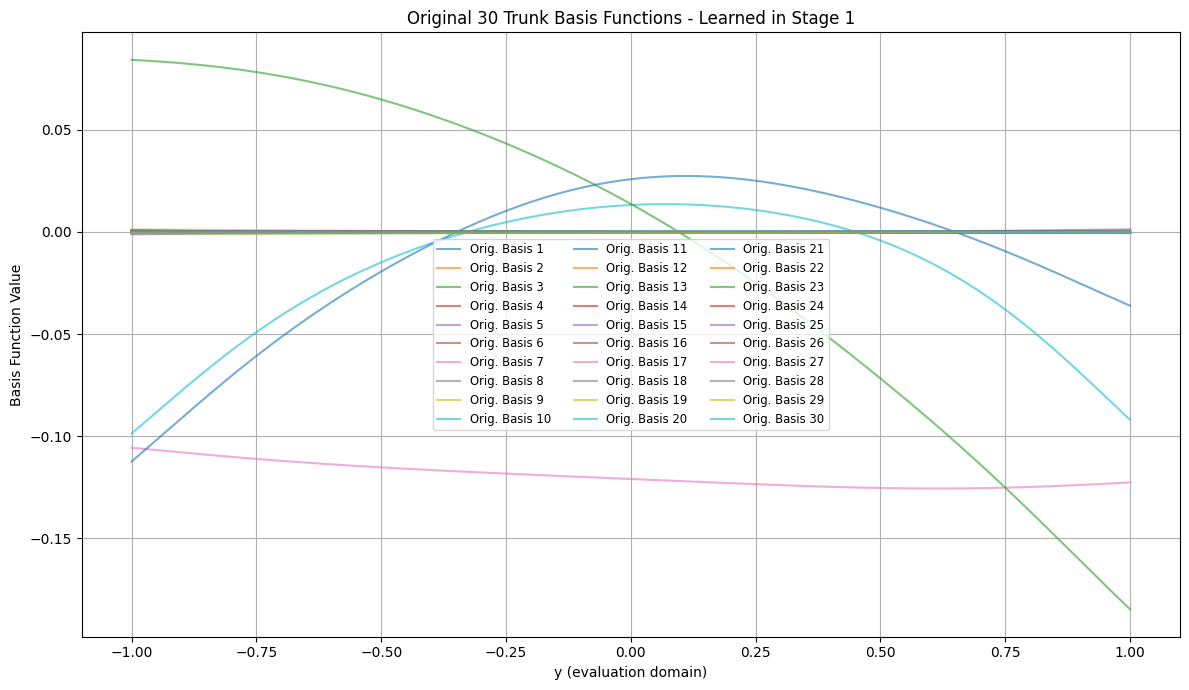

--- Plotting Gram Matrices for Original (All) Trunk Bases ---


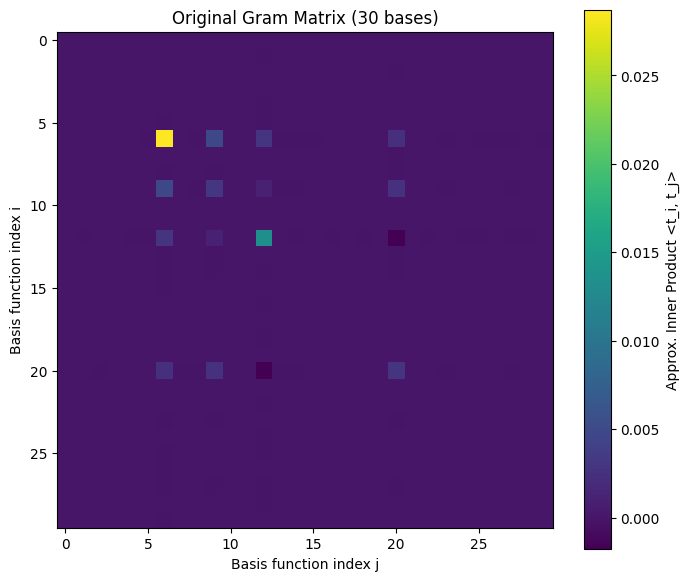

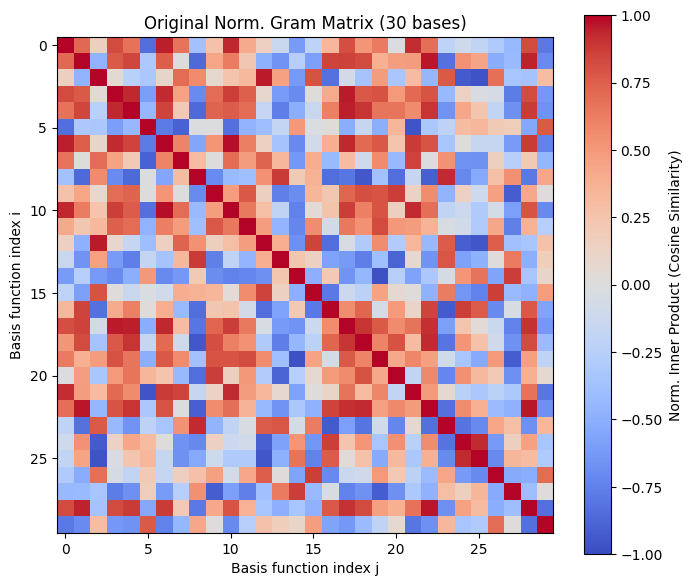

L2 norms of original basis functions: [2.87043134e-04 4.50775173e-04 2.74562190e-04 2.15638822e-04
 6.03436783e-04 1.64982877e-04 1.69380650e-01 2.44741736e-04
 6.86332700e-04 5.50190806e-02 3.82993545e-04 1.72373882e-04
 1.15596071e-01 3.01314198e-04 5.51242498e-04 3.06121714e-04
 4.54855181e-04 2.90666881e-04 2.96690967e-04 2.77720741e-04
 5.43016680e-02 2.77349085e-04 6.11697033e-04 3.71452363e-04
 3.38526763e-04 2.36680789e-04 2.70429911e-04 4.01880359e-04
 7.35884882e-04 4.03530052e-04]
Using L2 norm pruning threshold: 0.01
Number of original bases: 30
Number of surviving bases after pruning: 4
Indices of surviving bases: [ 6  9 12 20]

--- Plotting Gram Matrices for Surviving (4) Trunk Bases ---


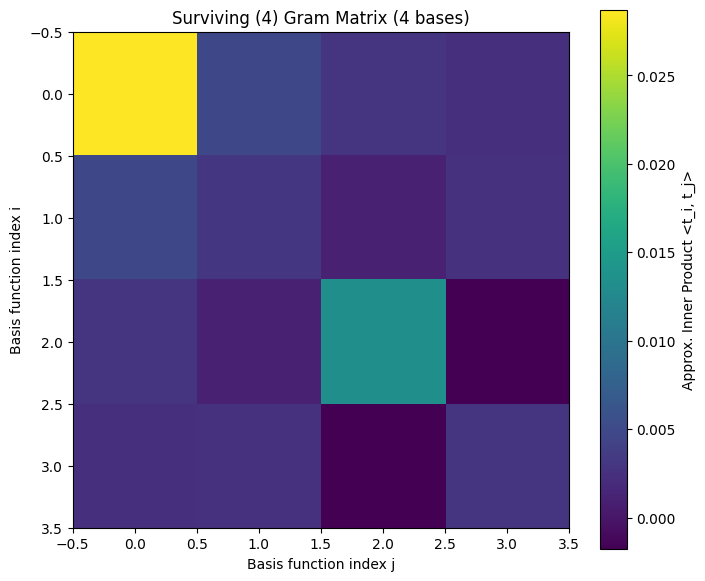

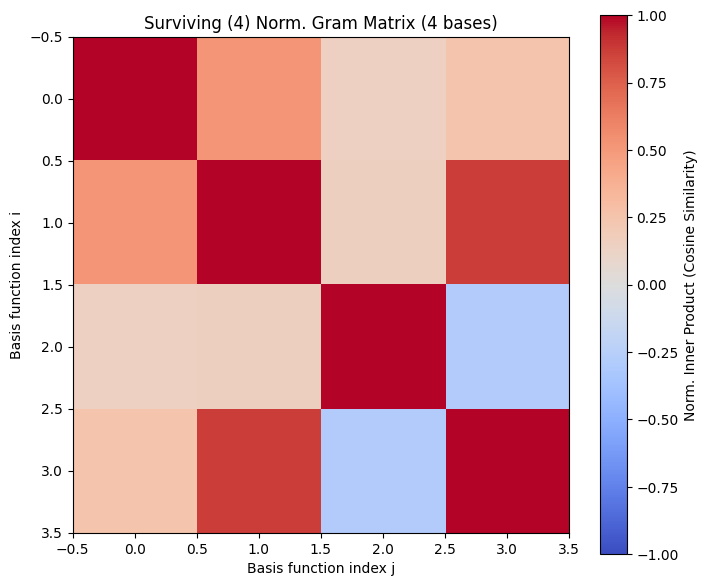


--- Defining Stage 2 Model (MLP Branch for 4 surviving bases) ---
--- Starting Stage 2 Training (with pruned basis) ---
Stage 2 (Pruned) - Epoch 0, Loss: 1.471545
Stage 2 (Pruned) - Epoch 1000, Loss: 0.001270
Stage 2 (Pruned) - Epoch 2000, Loss: 0.000564
Stage 2 (Pruned) - Epoch 3000, Loss: 0.000214
Stage 2 (Pruned) - Epoch 4000, Loss: 0.000151
Stage 2 (Pruned) - Epoch 5000, Loss: 0.000106
Stage 2 (Pruned) - Epoch 6000, Loss: 0.000075
Stage 2 (Pruned) - Epoch 7000, Loss: 0.000050
Stage 2 (Pruned) - Epoch 8000, Loss: 0.000104
Stage 2 (Pruned) - Epoch 9000, Loss: 0.000037
Stage 2 (Pruned) - Epoch 10000, Loss: 0.000039
Stage 2 (Pruned) - Epoch 11000, Loss: 0.000029
Stage 2 (Pruned) - Epoch 12000, Loss: 0.000021
Stage 2 (Pruned) - Epoch 13000, Loss: 0.000047
Stage 2 (Pruned) - Epoch 14000, Loss: 0.000022
Stage 2 (Pruned) - Epoch 15000, Loss: 0.000027
Stage 2 (Pruned) - Epoch 16000, Loss: 0.000019
Stage 2 (Pruned) - Epoch 17000, Loss: 0.000023
Stage 2 (Pruned) - Epoch 18000, Loss: 0.000021

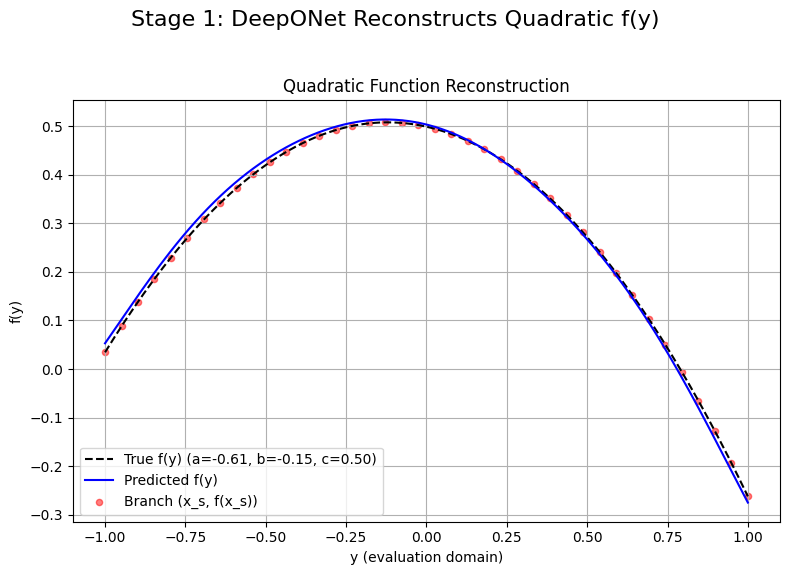


--- Plotting Stage 2 Example (Pruned Basis) ---


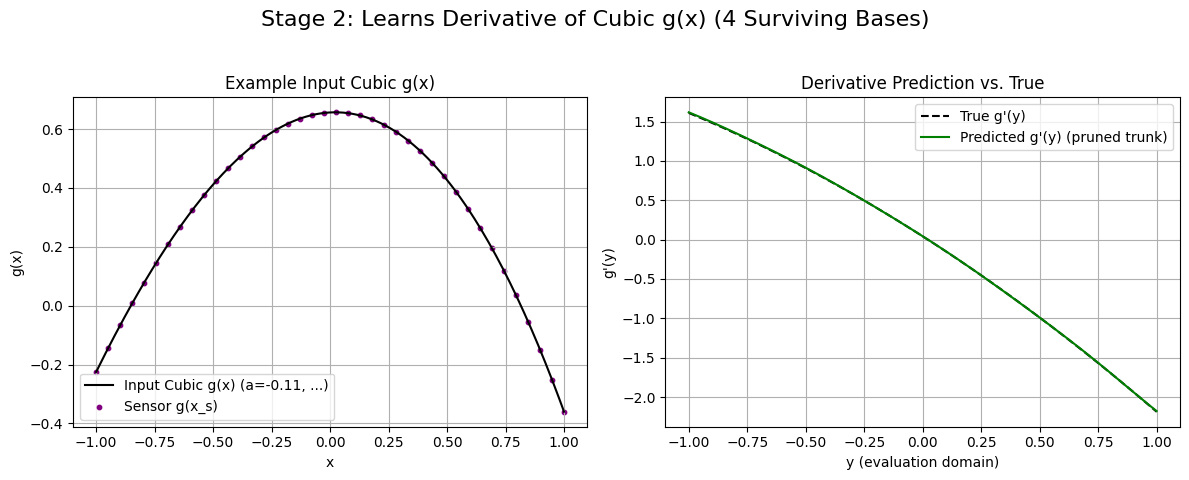


Stage 1: Avg L2 Rel Error (30 bases) over ~500 examples: 0.014304
Stage 2 (Pruned): Avg L2 Rel Error (4 surv. bases) over ~500 examples: 0.003677


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

# Hyperparameters
l1_lambda = 1e-5
lambda_cov_reg = 1e-1 # for covariance diagonalization regularization
input_range = [-1, 1]
scale = 1.0
sensor_size = 40
num_original_bases = 30

# Sensor x-coordinates
sensor_x_coords = torch.linspace(input_range[0], input_range[1], sensor_size)

# Trunk input points
def sample_trunk_points(n_points):
    return torch.linspace(input_range[0], input_range[1], n_points).view(-1, 1)

# --- Stage 1: Learn trunk basis for representing f(x)=ax^2+bx+c ---
def generate_batch_stage1(batch_size, n_trunk_points):
    a_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    b_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    c_quad = (torch.rand(batch_size, 1) * 2 - 1) * scale
    f_values_at_sensors = a_quad * sensor_x_coords**2 + b_quad * sensor_x_coords + c_quad
    sensor_x_coords_batch = sensor_x_coords.unsqueeze(0).repeat(batch_size, 1).unsqueeze(2)
    f_values_batch = f_values_at_sensors.unsqueeze(2)
    branch_input_deepset = torch.cat((sensor_x_coords_batch, f_values_batch), dim=2)
    y_trunk = sample_trunk_points(n_trunk_points)
    target_stage1 = a_quad * y_trunk.T**2 + b_quad * y_trunk.T + c_quad
    return branch_input_deepset, y_trunk, target_stage1, (a_quad, b_quad, c_quad)

# --- Stage 2: Learn MLP branch for derivatives of g(x)=ax^3+bx^2+cx+d ---
def generate_batch_stage2(batch_size, n_trunk_points):
    a_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    b_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    c_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    d_cub = (torch.rand(batch_size, 1) * 2 - 1) * scale
    g_values_at_sensors = a_cub * sensor_x_coords**3 + b_cub * sensor_x_coords**2 + \
                          c_cub * sensor_x_coords + d_cub
    branch_input_mlp = g_values_at_sensors
    y_trunk = sample_trunk_points(n_trunk_points)
    target_stage2 = 3 * a_cub * y_trunk.T**2 + 2 * b_cub * y_trunk.T + c_cub
    return branch_input_mlp, y_trunk, target_stage2, (a_cub, b_cub, c_cub, d_cub)

# MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# DeepSet Branch Network
class DeepSetBranch(nn.Module):
    def __init__(self, element_dim, phi_hidden_dims, phi_output_dim,
                 rho_hidden_dims, branch_output_dim, activation=nn.Tanh):
        super().__init__()
        self.phi = MLP(element_dim, phi_hidden_dims, phi_output_dim, activation)
        self.rho = MLP(phi_output_dim, rho_hidden_dims, branch_output_dim, activation)
    def forward(self, set_elements):
        phi_out = self.phi(set_elements)
        sum_phi_out = torch.sum(phi_out, dim=1)
        branch_embedding = self.rho(sum_phi_out)
        return branch_embedding

# Standard DeepONet model
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)
        t = self.trunk_net(trunk_input) # t has shape [M_trunk_points, P_bases]
        out = torch.matmul(b, t.T)
        return out

# DeepONet for Pruned Stage 2
class PrunedDeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net, surviving_trunk_indices):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
        self.surviving_trunk_indices = surviving_trunk_indices
    def forward(self, branch_input, trunk_input):
        b_prime = self.branch_net(branch_input)
        t_all = self.trunk_net(trunk_input)
        indices_on_device = self.surviving_trunk_indices.to(t_all.device)
        t_survivors = t_all[:, indices_on_device]
        out = torch.matmul(b_prime, t_survivors.T)
        return out

# --- Network Hyperparameters ---
element_input_dim_ds = 2
phi_hidden_dims_ds = [64, 128]
phi_output_dim_ds = 128
rho_hidden_dims_ds = [128, 64]
mlp_branch_input_dim_stage2 = sensor_size
mlp_branch_hidden_dims_stage2 = [128, 64]

# --- Stage 1: Define and Train ---
print("--- Defining Stage 1 Model ---")
branch_s1_deepset = DeepSetBranch(
    element_dim=element_input_dim_ds, phi_hidden_dims=phi_hidden_dims_ds,
    phi_output_dim=phi_output_dim_ds, rho_hidden_dims=rho_hidden_dims_ds,
    branch_output_dim=num_original_bases, activation=nn.Tanh
)
trunk_net_original = MLP(input_dim=1, hidden_dims=[64, 64, 64], output_dim=num_original_bases, activation=nn.Tanh)
model_s1 = DeepONet(branch_net=branch_s1_deepset, trunk_net=trunk_net_original)
loss_fn_s1 = nn.MSELoss()
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=1e-3)
epochs_s1 = 25000
print("--- Starting Stage 1 Training ---")
for epoch in range(epochs_s1):
    model_s1.train()
    branch_in, trunk_in, target, _ = generate_batch_stage1(batch_size=64, n_trunk_points=50) # trunk_in is [M,1]

    pred = model_s1(branch_in, trunk_in)
    reconstruction_loss = loss_fn_s1(pred, target)

    # L1 Regularization on trunk outputs (original)
    # We need the trunk outputs for the current trunk_in batch
    T_batch_for_l1 = model_s1.trunk_net(trunk_in) # [M, P]
    l1_reg = l1_lambda * torch.norm(T_batch_for_l1, p=1)

    # Mini-Batch Covariance Diagonalization Regularization
    loss_cov_term = torch.tensor(0.0, device=reconstruction_loss.device) # Ensure same device
    if lambda_cov_reg > 0 and T_batch_for_l1.shape[0] > 1 and T_batch_for_l1.shape[1] > 1: # M > 1, P > 1
        M_points = T_batch_for_l1.shape[0]
        P_bases = T_batch_for_l1.shape[1]

        # Center each basis function (column)
        T_centered = T_batch_for_l1 - T_batch_for_l1.mean(dim=0, keepdim=True) # [M, P]

        # Sample covariance matrix: (1/(M-1)) * T_centered.T @ T_centered
        # Using (1/M) for simplicity if M is reasonably large, or (1/(M-1))
        cov_matrix_batch = (1.0 / (M_points - 1 + 1e-8)) * (T_centered.T @ T_centered) # [P, P]

        # Penalty: sum of squares of off-diagonal elements
        # Create a mask for off-diagonal elements
        off_diag_mask = torch.ones_like(cov_matrix_batch) - torch.eye(P_bases, device=cov_matrix_batch.device)
        loss_cov_term = torch.sum((cov_matrix_batch * off_diag_mask)**2)

    loss = reconstruction_loss + l1_reg + lambda_cov_reg * loss_cov_term

    optimizer_s1.zero_grad()
    loss.backward()
    optimizer_s1.step()

    if epoch % 1000 == 0:
        print(f"Stage 1 - Epoch {epoch}, Loss: {loss.item():.6f}, Recon: {reconstruction_loss.item():.6f}, L1: {l1_reg.item():.4f}, Cov: {(lambda_cov_reg * loss_cov_term).item():.4f}")

for param in trunk_net_original.parameters():
    param.requires_grad = False
print("\n--- Original Trunk network frozen ---")

# --- Gram Matrix Plotting Function ---
def plot_gram_matrices(basis_values_np, num_bases_to_plot, dy_spacing, title_prefix=""):
    # (Function remains the same as before)
    gram_matrix = np.zeros((num_bases_to_plot, num_bases_to_plot))
    for r_idx in range(num_bases_to_plot):
        for c_idx in range(r_idx, num_bases_to_plot):
            inner_prod = np.sum(basis_values_np[:, r_idx] * basis_values_np[:, c_idx]) * dy_spacing
            gram_matrix[r_idx, c_idx] = inner_prod
            if r_idx != c_idx: gram_matrix[c_idx, r_idx] = inner_prod

    plt.figure(figsize=(8, 7))
    plt.imshow(gram_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Approx. Inner Product <t_i, t_j>')
    plt.title(f'{title_prefix}Gram Matrix ({num_bases_to_plot} bases)')
    plt.xlabel('Basis function index j')
    plt.ylabel('Basis function index i')
    plt.grid(False)
    plt.show()

    normalized_gram_matrix = np.zeros((num_bases_to_plot, num_bases_to_plot))
    norms_squared = np.diag(gram_matrix)
    norms = np.sqrt(np.maximum(norms_squared, 1e-12))

    for r_idx in range(num_bases_to_plot):
        for c_idx in range(num_bases_to_plot):
            if norms[r_idx] > 1e-9 and norms[c_idx] > 1e-9:
                 normalized_gram_matrix[r_idx,c_idx] = gram_matrix[r_idx,c_idx] / (norms[r_idx] * norms[c_idx])
            else:
                 normalized_gram_matrix[r_idx,c_idx] = 0.0 if r_idx!=c_idx else (1.0 if norms[r_idx] > 1e-9 else 0.0)

    plt.figure(figsize=(8, 7))
    plt.imshow(normalized_gram_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
    plt.colorbar(label='Norm. Inner Product (Cosine Similarity)')
    plt.title(f'{title_prefix}Norm. Gram Matrix ({num_bases_to_plot} bases)')
    plt.xlabel('Basis function index j')
    plt.ylabel('Basis function index i')
    plt.grid(False)
    plt.show()


# --- Pruning Step & Gram Matrix Plotting (Before Pruning) ---
print("\n--- Evaluating Original Trunk Basis Functions (Before Pruning) ---")
x_dense_plot = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1)
dy_spacing = (x_dense_plot[1,0] - x_dense_plot[0,0]).item()
with torch.no_grad():
    trunk_net_original.eval()
    trunk_out_all_bases_values = trunk_net_original(x_dense_plot).numpy()

plt.figure(figsize=(12, 7))
for i in range(num_original_bases):
    plt.plot(x_dense_plot.squeeze().numpy(), trunk_out_all_bases_values[:, i], label=f"Orig. Basis {i+1}", alpha=0.6)
plt.title(f"Original {num_original_bases} Trunk Basis Functions - Learned in Stage 1")
# (Rest of plotting and pruning code remains the same as your last version)
plt.xlabel("y (evaluation domain)")
plt.ylabel("Basis Function Value")
plt.legend(fontsize='small', ncol=max(1, num_original_bases // 10))
plt.grid(True)
plt.tight_layout()
plt.show()

print("--- Plotting Gram Matrices for Original (All) Trunk Bases ---")
plot_gram_matrices(trunk_out_all_bases_values, num_original_bases, dy_spacing, title_prefix="Original ")

# Pruning based on L2 norm
l2_norms_orig = np.zeros(num_original_bases)
for i in range(num_original_bases):
    l2_norms_orig[i] = np.sqrt(np.sum(trunk_out_all_bases_values[:, i]**2) * dy_spacing)
print("L2 norms of original basis functions:", l2_norms_orig)
pruning_threshold = 1e-2
print(f"Using L2 norm pruning threshold: {pruning_threshold}")
surviving_indices = np.where(l2_norms_orig > pruning_threshold)[0]
num_survivors = len(surviving_indices)
if num_survivors == 0:
    print("WARNING: No basis functions survived pruning! Using the one with max norm.")
    if num_original_bases > 0 and np.max(l2_norms_orig) > 0:
        surviving_indices = np.array([np.argmax(l2_norms_orig)])
        num_survivors = 1
    else:
        raise ValueError("All original basis functions have zero norm. Check Stage 1.")
print(f"Number of original bases: {num_original_bases}")
print(f"Number of surviving bases after pruning: {num_survivors}")
print(f"Indices of surviving bases: {surviving_indices}")
surviving_indices_tensor = torch.tensor(surviving_indices, dtype=torch.long)

# --- Gram Matrix Plotting (After Pruning) ---
if num_survivors > 0 and num_survivors < num_original_bases :
    print(f"\n--- Plotting Gram Matrices for Surviving ({num_survivors}) Trunk Bases ---")
    trunk_out_surviving_bases_values = trunk_out_all_bases_values[:, surviving_indices]
    plot_gram_matrices(trunk_out_surviving_bases_values, num_survivors, dy_spacing, title_prefix=f"Surviving ({num_survivors}) ")
elif num_survivors == num_original_bases:
    print("\n--- No pruning occurred, all bases survived. Gram matrices for surviving bases are same as original. ---")
else:
    print("\n--- Skipping Gram matrices for surviving bases as no/all bases survived in a typical pruning scenario. ---")


# --- Stage 2: Define and Train with Pruned Basis ---
print(f"\n--- Defining Stage 2 Model (MLP Branch for {num_survivors} surviving bases) ---")
branch_s2_mlp_pruned = MLP(
    input_dim=mlp_branch_input_dim_stage2, hidden_dims=mlp_branch_hidden_dims_stage2,
    output_dim=num_survivors, activation=nn.ReLU
)
model_s2_pruned = PrunedDeepONet(
    branch_net=branch_s2_mlp_pruned, trunk_net=trunk_net_original,
    surviving_trunk_indices=surviving_indices_tensor
)
loss_fn_s2 = nn.MSELoss()
optimizer_s2 = optim.Adam(model_s2_pruned.branch_net.parameters(), lr=5e-4)
epochs_s2 = 20000
print("--- Starting Stage 2 Training (with pruned basis) ---")
for epoch in range(epochs_s2):
    model_s2_pruned.branch_net.train()
    model_s2_pruned.trunk_net.eval()
    branch_in, trunk_in, target, _ = generate_batch_stage2(batch_size=64, n_trunk_points=50)
    pred = model_s2_pruned(branch_in, trunk_in)
    loss = loss_fn_s2(pred, target)
    optimizer_s2.zero_grad()
    loss.backward()
    optimizer_s2.step()
    if epoch % 1000 == 0:
        print(f"Stage 2 (Pruned) - Epoch {epoch}, Loss: {loss.item():.6f}")

# --- Evaluation and Plotting ---
# (Plotting and final error calculation code remains the same as your last version)
print("\n--- Plotting Stage 1 Example ---")
fig1_s1, ax1_s1 = plt.subplots(1, 1, figsize=(8, 6))
fig1_s1.suptitle("Stage 1: DeepONet Reconstructs Quadratic f(y)", fontsize=16)
branch_in_plot_s1, _, target_plot_s1, (a_q, b_q, c_q) = generate_batch_stage1(batch_size=1, n_trunk_points=x_dense_plot.shape[0])
with torch.no_grad():
    model_s1.eval()
    pred_plot_s1 = model_s1(branch_in_plot_s1, x_dense_plot).squeeze()
ax1_s1.plot(x_dense_plot.numpy(), target_plot_s1.squeeze().numpy(), 'k--', label=f'True f(y) (a={a_q.item():.2f}, b={b_q.item():.2f}, c={c_q.item():.2f})')
ax1_s1.plot(x_dense_plot.numpy(), pred_plot_s1.numpy(), 'b-', label="Predicted f(y)")
sensor_vals_plot_s1 = a_q.item() * sensor_x_coords**2 + b_q.item() * sensor_x_coords + c_q.item()
ax1_s1.scatter(sensor_x_coords.numpy(), sensor_vals_plot_s1.numpy(), color='red', marker='o', label='Branch (x_s, f(x_s))', alpha=0.5, s=20)
ax1_s1.set_title("Quadratic Function Reconstruction")
ax1_s1.set_xlabel("y (evaluation domain)")
ax1_s1.set_ylabel("f(y)")
ax1_s1.legend()
ax1_s1.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Plotting Stage 2 Example (Pruned Basis) ---")
fig2_s2, axs2_s2 = plt.subplots(1, 2, figsize=(12, 5))
fig2_s2.suptitle(f"Stage 2: Learns Derivative of Cubic g(x) ({num_survivors} Surviving Bases)", fontsize=16)
branch_in_plot_s2, _, target_plot_s2, (a_c,b_c,c_c,d_c) = generate_batch_stage2(batch_size=1, n_trunk_points=x_dense_plot.shape[0])
g_x_plot_s2 = a_c.item() * x_dense_plot.squeeze()**3 + b_c.item() * x_dense_plot.squeeze()**2 + \
              c_c.item() * x_dense_plot.squeeze() + d_c.item()
with torch.no_grad():
    model_s2_pruned.eval()
    pred_plot_s2 = model_s2_pruned(branch_in_plot_s2, x_dense_plot).squeeze()
axs2_s2[0].plot(x_dense_plot.numpy(), g_x_plot_s2.numpy(), 'k-', label=f'Input Cubic g(x) (a={a_c.item():.2f}, ...)')
sensor_vals_plot_s2 = a_c.item() * sensor_x_coords**3 + b_c.item() * sensor_x_coords**2 + \
                      c_c.item() * sensor_x_coords + d_c.item()
axs2_s2[0].scatter(sensor_x_coords.numpy(), sensor_vals_plot_s2.numpy(), color='purple', label='Sensor g(x_s)', s=10)
axs2_s2[0].set_title("Example Input Cubic g(x)")
axs2_s2[0].set_xlabel("x")
axs2_s2[0].set_ylabel("g(x)")
axs2_s2[0].legend()
axs2_s2[0].grid(True)
axs2_s2[1].plot(x_dense_plot.numpy(), target_plot_s2.squeeze().numpy(), 'k--', label="True g'(y)")
axs2_s2[1].plot(x_dense_plot.numpy(), pred_plot_s2.numpy(), 'g-', label="Predicted g'(y) (pruned trunk)")
axs2_s2[1].set_title("Derivative Prediction vs. True")
axs2_s2[1].set_xlabel("y (evaluation domain)")
axs2_s2[1].set_ylabel("g'(y)")
axs2_s2[1].legend()
axs2_s2[1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final L2 relative error for Stage 1
with torch.no_grad():
    model_s1.eval()
    n_test_s1 = 500; errors_s1 = []
    for _ in range(n_test_s1 // 64 +1):
        branch_input_test, trunk_input_test, y_true_test, _ = generate_batch_stage1(batch_size=64, n_trunk_points=100)
        y_pred_test = model_s1(branch_input_test, trunk_input_test)
        error_s1_batch = torch.norm(y_pred_test - y_true_test, dim=1) / (torch.norm(y_true_test, dim=1) + 1e-8)
        errors_s1.extend(error_s1_batch.tolist())
    rel_error_s1 = np.mean(errors_s1)
    print(f"\nStage 1: Avg L2 Rel Error ({num_original_bases} bases) over ~{n_test_s1} examples: {rel_error_s1:.6f}")

# Final L2 relative error for Stage 2 (pruned)
with torch.no_grad():
    model_s2_pruned.eval()
    n_test_s2 = 500; errors_s2 = []
    for _ in range(n_test_s2 // 64 + 1):
        branch_input_test, trunk_input_test, y_true_test, _ = generate_batch_stage2(batch_size=64, n_trunk_points=100)
        y_pred_test = model_s2_pruned(branch_input_test, trunk_input_test)
        error_s2_batch = torch.norm(y_pred_test - y_true_test, dim=1) / (torch.norm(y_true_test, dim=1) + 1e-8)
        errors_s2.extend(error_s2_batch.tolist())
    rel_error_s2 = np.mean(errors_s2)
    print(f"Stage 2 (Pruned): Avg L2 Rel Error ({num_survivors} surv. bases) over ~{n_test_s2} examples: {rel_error_s2:.6f}")

## Helper Functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

# simple MLP calss
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DeepSets(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 phi_layers=2, rho_layers=2,
                 aggregation='sum'):
        super().__init__()

        assert aggregation in ['sum', 'mean', 'max'], "Invalid aggregation function"
        self.aggregation = aggregation

        # φ network: maps each element of the set
        phi_layers_list = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(phi_layers - 1):
            phi_layers_list.append(nn.Linear(hidden_dim, hidden_dim))
            phi_layers_list.append(nn.ReLU())
        self.phi = nn.Sequential(*phi_layers_list)

        # ρ network: maps aggregated embedding to output
        rho_layers_list = [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        for _ in range(rho_layers - 1):
            rho_layers_list.append(nn.Linear(hidden_dim, hidden_dim))
            rho_layers_list.append(nn.ReLU())
        rho_layers_list.append(nn.Linear(hidden_dim, output_dim))
        self.rho = nn.Sequential(*rho_layers_list)

    def forward(self, x):
        # x: shape [batch_size, set_size, input_dim]
        B, N, D = x.shape
        phi_x = self.phi(x)  # [B, N, hidden_dim]

        if self.aggregation == 'sum':
            agg = phi_x.sum(dim=1)
        elif self.aggregation == 'mean':
            agg = phi_x.mean(dim=1)
        elif self.aggregation == 'max':
            agg = phi_x.max(dim=1).values

        return self.rho(agg)

# DeepONet model
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net

    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)  # [batch, d]
        t = self.trunk_net(trunk_input)    # [batch, d]
        out = torch.matmul(b, t.T)         # scalar output
        return out

In [ ]:
# density function example, specific for deep sets
def gaussian_mixture_density(batch_size, n, m=400, domain_bounds=[-5, 5]):
    """
    Generate batch of 2D Gaussian mixture densities.

    Args:
        batch_size (int): Number of different density functions to generate.
        n (int): Number of collocation points.
        m (int): Number of branch samples from each density.
        domain_bounds (list): 2D domain to sample x from, default [-5, 5].

    Returns:
        x: Tensor of shape (n, 2) – collocation points.
        y: Tensor of shape (batch_size, n) – density values p_i(x_j).
        branch_input: Tensor of shape (batch_size, m, 2) – samples from each mixture.
    """

    # Sample n collocation points in 2D uniformly
    x = torch.rand(n, 2) * (domain_bounds[1] - domain_bounds[0]) + domain_bounds[0]

    y = torch.zeros(batch_size, n)
    branch_input = torch.zeros(batch_size, m, 2)

    for i in range(batch_size):
        # Random means and covariance matrices for 2 Gaussians
        mean1 = torch.empty(2).uniform_(-2, 2)
        mean2 = torch.empty(2).uniform_(-2, 2)

        cov1 = torch.diag(torch.empty(2).uniform_(0.2, 1.0))
        cov2 = torch.diag(torch.empty(2).uniform_(0.2, 1.0))

        dist1 = MultivariateNormal(mean1, covariance_matrix=cov1)
        dist2 = MultivariateNormal(mean2, covariance_matrix=cov2)

        # Compute mixture density at collocation points
        p1 = torch.exp(dist1.log_prob(x))
        p2 = torch.exp(dist2.log_prob(x))
        y[i] = 0.5 * p1 + 0.5 * p2

        # Sample m points from the mixture
        idx = torch.bernoulli(torch.full((m,), 0.5)).bool()
        samples = torch.zeros(m, 2)
        samples[idx] = dist1.sample((idx.sum(),))
        samples[~idx] = dist2.sample((m - idx.sum(),))
        branch_input[i] = samples

    return x, y, branch_input

def plot_density_and_samples(x, y, branch_input, domain_bounds=[-5, 5]):
    """
    Visualize 3 density functions and their sampled points.

    Args:
        x: (n, 2) tensor of collocation points
        y: (batch_size, n) tensor of density values at collocation points
        branch_input: (batch_size, m, 2) tensor of sampled points per density
        domain_bounds: list of [min, max] for 2D domain
    """
    batch_size = y.shape[0]
    assert batch_size >= 3, "Need at least 3 batch instances to plot."

    x_np = x.cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Set up a grid for image plotting
    resolution = 100
    x_grid = np.linspace(domain_bounds[0], domain_bounds[1], resolution)
    y_grid = np.linspace(domain_bounds[0], domain_bounds[1], resolution)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=-1)  # shape (res*res, 2)

    for i in range(3):
        ax = axes[i]

        # Interpolate y[i] onto the grid
        from scipy.interpolate import griddata
        density_grid = griddata(
            x_np, y[i].cpu().numpy(), grid_points, method='cubic', fill_value=0
        ).reshape(resolution, resolution)

        ax.imshow(
            density_grid,
            extent=(domain_bounds[0], domain_bounds[1], domain_bounds[0], domain_bounds[1]),
            origin='lower',
            cmap='viridis',
            alpha=0.9
        )

        samples = branch_input[i].cpu().numpy()
        ax.scatter(samples[:, 0], samples[:, 1], s=10, c='red', alpha=0.6, label='Samples')
        ax.set_title(f'Density #{i}')
        ax.set_xlim(domain_bounds)
        ax.set_ylim(domain_bounds)
        ax.legend()

    plt.tight_layout()
    plt.show()

## Deep Sets Density Function Mapping

Using device: cuda
Epoch 0, Loss: 9.379711
Epoch 1000, Loss: 0.971325
Epoch 2000, Loss: 0.741325
Epoch 3000, Loss: 0.478850
Epoch 4000, Loss: 0.371634
Epoch 5000, Loss: 0.367940
Epoch 6000, Loss: 0.361835
Epoch 7000, Loss: 0.294043
Epoch 8000, Loss: 0.236693
Epoch 9000, Loss: 0.265077
Epoch 10000, Loss: 0.223583
Epoch 11000, Loss: 0.290866
Epoch 12000, Loss: 0.235279
Epoch 13000, Loss: 0.253714
Epoch 14000, Loss: 0.265603
Epoch 15000, Loss: 0.215586
Epoch 16000, Loss: 0.220166
Epoch 17000, Loss: 0.264059
Epoch 18000, Loss: 0.262273
Epoch 19000, Loss: 0.232739

Average L2 Relative Error over 1000 test examples: 0.142043


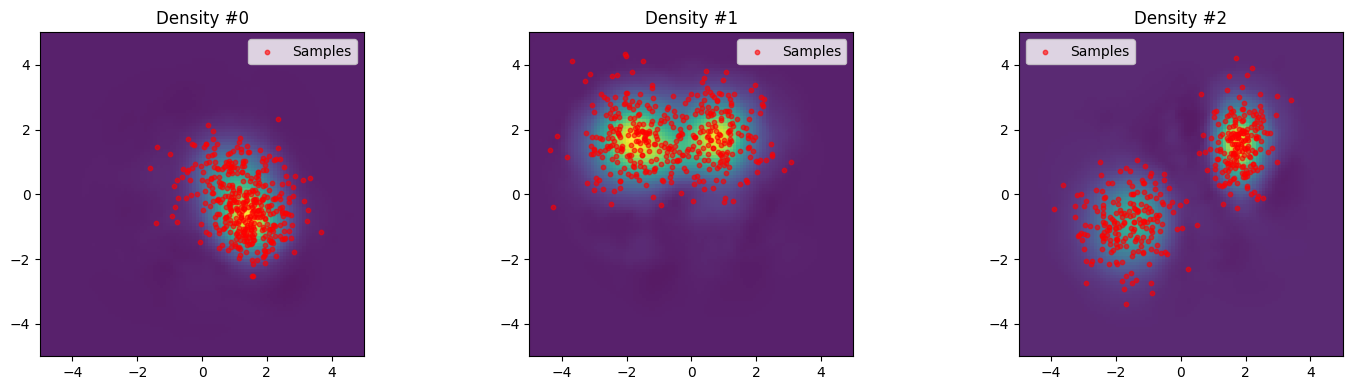

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

'''
Some default hyperparameters
domain boundary: [-5, 5]
gaussian mean: [-2, 2]
gaussian cov:  [0.2, 1.0]
'''


# Define DeepONet structure, even though only for single function space
branch_net = DeepSets(input_dim=2, hidden_dim=256, output_dim=100, aggregation='mean')
trunk_net = MLP(input_dim=2, hidden_dims=[256, 256, 256], output_dim=100, activation=nn.ReLU)
model = DeepONet(branch_net=branch_net, trunk_net=trunk_net).to(device)

# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20000):
    model.train()
    trunk_input, target, branch_input = gaussian_mixture_density(batch_size=64, n=1000)
    branch_input = branch_input.to(device)
    trunk_input = trunk_input.to(device)
    target = 100*target.to(device)
    pred = model(branch_input, trunk_input)
    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

model.eval()
# l2 relative error over large batch
with torch.no_grad():
    n_test = 1000
    trunk_input, y_true, branch_input = gaussian_mixture_density(batch_size=n_test, n=2000)
    branch_input = branch_input.to(device)
    trunk_input = trunk_input.to(device)
    y_true = 100*y_true.to(device)
    y_pred = model(branch_input, trunk_input)
    error = torch.norm(y_pred - y_true, dim=1)
    denom = torch.norm(y_true, dim=1)
    rel_error = (error / denom).mean()
    print(f"\nAverage L2 Relative Error over {n_test} test examples: {rel_error:.6f}")

plot_density_and_samples(trunk_input.detach(), y_pred.detach(), branch_input.detach())

## SetONet Derivative example

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
Epoch 0, Loss: 1.125038
Epoch 1000, Loss: 0.519539
Epoch 2000, Loss: 0.041454
Epoch 3000, Loss: 0.023554
Epoch 4000, Loss: 0.039404

Average L2 Relative Error over 1000 test examples: 0.162972


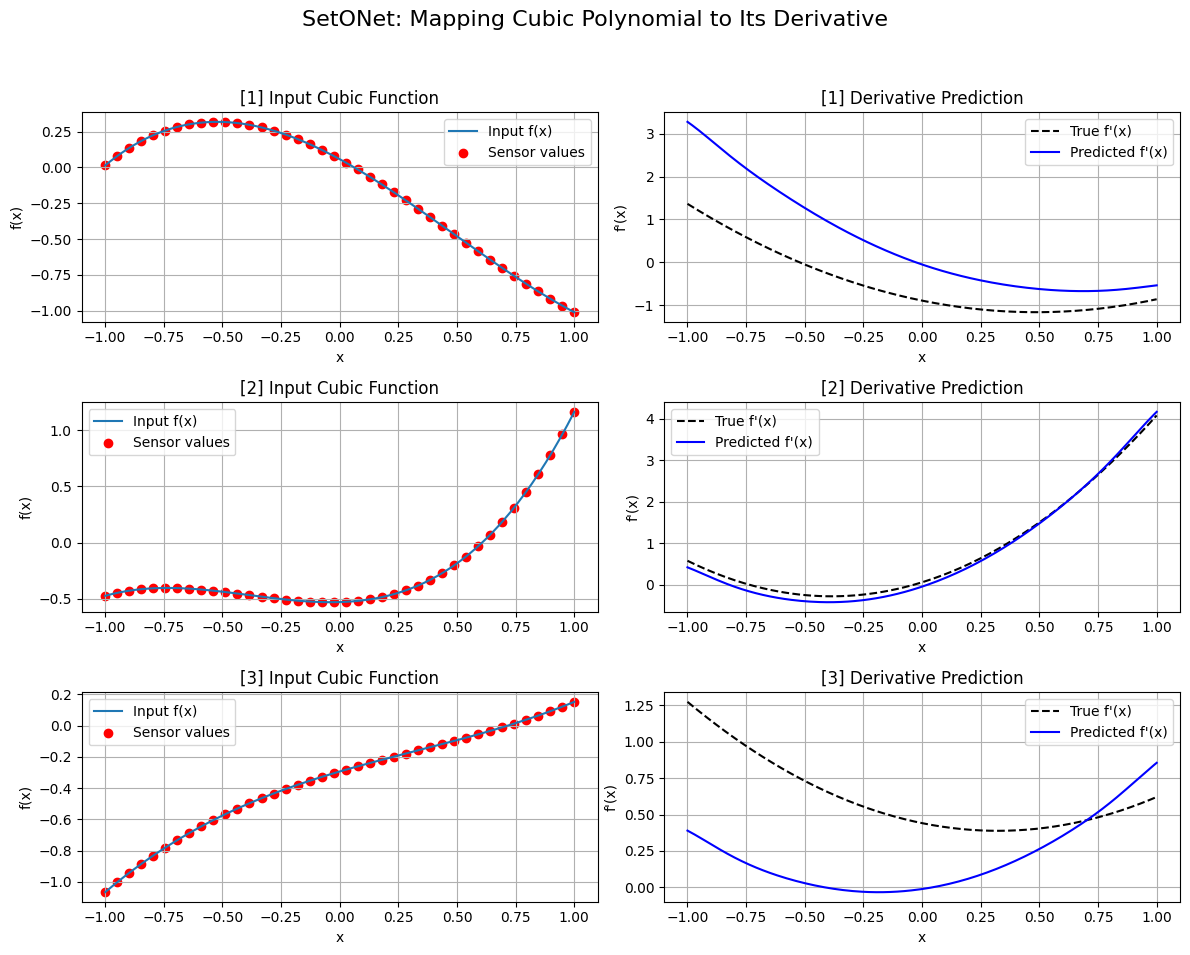

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

# some hyperparmeters for the problem
input_range = [-1,1]
scale = 1
sensor_size = 40

# Sensor points (fixed for branch input)
sensor_x = torch.linspace(input_range[0], input_range[1], sensor_size)  # e.g., 40 equidistant points
sensor_index = torch.tensor(list(range(sensor_size))); print(sensor_index)

# Trunk input points (evaluation x)
def sample_trunk_points(n_points):
    # return (input_range[1]-input_range[0]) * torch.rand(n_points, 1) + input_range[0]
    return torch.linspace(input_range[0], input_range[1], n_points).view(-1,1)

# Generate a batch of cubic polynomials
def generate_batch(batch_size, n_trunk_points):
    a = torch.rand(batch_size, 1) * 2 - 1
    b = torch.rand(batch_size, 1) * 2 - 1
    c = torch.rand(batch_size, 1) * 2 - 1
    d = torch.rand(batch_size, 1) * 2 - 1
    a, b, c, d = a * scale, b * scale, c * scale, d * scale

    f_values = a * sensor_x**3 + b * sensor_x**2 + c * sensor_x + d  # [B, S]
    f_values = torch.cat([sensor_index.unsqueeze(0).expand(batch_size, -1).unsqueeze(-1), f_values.unsqueeze(-1)], dim=-1)  # [B, S, 2] use for DeepSets

    x = sample_trunk_points(n_trunk_points)  # [T, 1]
    y = 3*a * x.T**2 + 2*b * x.T + c * x.T   # [B, T]
    return f_values, x, y

# Define DeepONet structure, even though only for single function space
branch_net = DeepSets(input_dim=2, hidden_dim=64, output_dim=20, aggregation='mean')
trunk_net = MLP(input_dim=1, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh)
model = DeepONet(branch_net=branch_net, trunk_net=trunk_net).to(device)

# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(5000):
    model.train()
    branch_input, trunk_input, target = generate_batch(batch_size=64, n_trunk_points=40)
    branch_input = branch_input.to(device)
    trunk_input = trunk_input.to(device)
    target = target.to(device)
    pred = model(branch_input, trunk_input)
    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

model.eval()
# l2 relative error over large batch
with torch.no_grad():
    n_test = 1000
    branch_input, trunk_input, y_true = generate_batch(batch_size=n_test, n_trunk_points=100)
    branch_input = branch_input.to(device)
    trunk_input = trunk_input.to(device)
    y_true = y_true.to(device)
    y_pred = model(branch_input, trunk_input)
    error = torch.norm(y_pred - y_true, dim=1)
    denom = torch.norm(y_true, dim=1)
    rel_error = (error / denom).mean()
    print(f"\nAverage L2 Relative Error over {n_test} test examples: {rel_error:.6f}")



x_dense = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1).to(device)  # [200, 1]
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("SetONet: Mapping Cubic Polynomial to Its Derivative", fontsize=16)

for i in range(3):
    # Random cubic coefficients
    a = 2*torch.rand(1).item()-1
    b = 2*torch.rand(1).item()-1
    c = 2*torch.rand(1).item()-1
    d = 2*torch.rand(1).item()-1

    # Compute input (function values at sensor points)
    f_sensor = a * sensor_x**3 + b * sensor_x**2 + c * sensor_x + d  # [S]
    f_dense = a * x_dense.squeeze()**3 + b * x_dense.squeeze()**2 + c * x_dense.squeeze() + d  # [200]
    df_true = 3*a*x_dense.squeeze()**2 + 2*b*x_dense.squeeze() + c  # [200]

    # Prepare DeepONet input: branch_input should be [B, S], we simulate batch_size = 1
    f_sensor = f_sensor.unsqueeze(0)  # [1, S]
    branch_input = torch.cat([sensor_index.unsqueeze(0).expand(1, -1).unsqueeze(-1), f_sensor.unsqueeze(-1)], dim=-1).to(device)  # [1, S, 2]

    # Compute predictions for the dense x values
    with torch.no_grad():
        df_pred = model(branch_input, x_dense).squeeze()  # [200]

    # Plot function input (cubic polynomial)
    axs[i, 0].plot(x_dense.squeeze().cpu().detach().numpy(), f_dense.cpu().detach().numpy(), label="Input f(x)")  # Dense f(x)
    axs[i, 0].scatter(sensor_x.cpu().detach().numpy(), f_sensor.cpu().detach().numpy(), color="red", label="Sensor values")  # Sensor points
    axs[i, 0].set_title(f"[{i+1}] Input Cubic Function")
    axs[i, 0].set_xlabel("x")
    axs[i, 0].set_ylabel("f(x)")
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Plot true vs predicted derivative
    axs[i, 1].plot(x_dense.squeeze().cpu().detach().numpy(), df_true.cpu().detach().numpy(), 'k--', label="True f'(x)")  # True derivative
    axs[i, 1].plot(x_dense.squeeze().cpu().detach().numpy(), df_pred.cpu().detach().numpy(), 'b-', label="Predicted f'(x)")  # Predicted derivative
    axs[i, 1].set_title(f"[{i+1}] Derivative Prediction")
    axs[i, 1].set_xlabel("x")
    axs[i, 1].set_ylabel("f'(x)")
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## DeepSets Orthogonality Study --XL

Is it true that Deep Sets promote orthogonality in basis learning of a function space? Answer: No

In fact DeepONet + regularization can do that in a more consistent way!!!

Epoch 0, Loss: 0.558907
Epoch 1000, Loss: 0.003953
Epoch 2000, Loss: 0.002919
Epoch 3000, Loss: 0.002348
Epoch 4000, Loss: 0.001979
Epoch 5000, Loss: 0.002335
Epoch 6000, Loss: 0.001407
Epoch 7000, Loss: 0.001668
Epoch 8000, Loss: 0.001296
Epoch 9000, Loss: 0.001101
Epoch 10000, Loss: 0.001090
Epoch 11000, Loss: 0.000877
Epoch 12000, Loss: 0.000837
Epoch 13000, Loss: 0.000612
Epoch 14000, Loss: 0.000844
Epoch 15000, Loss: 0.000582
Epoch 16000, Loss: 0.000652
Epoch 17000, Loss: 0.000458
Epoch 18000, Loss: 0.000483
Epoch 19000, Loss: 0.000474

Average L2 Relative Error over 1000 test examples: 0.022009


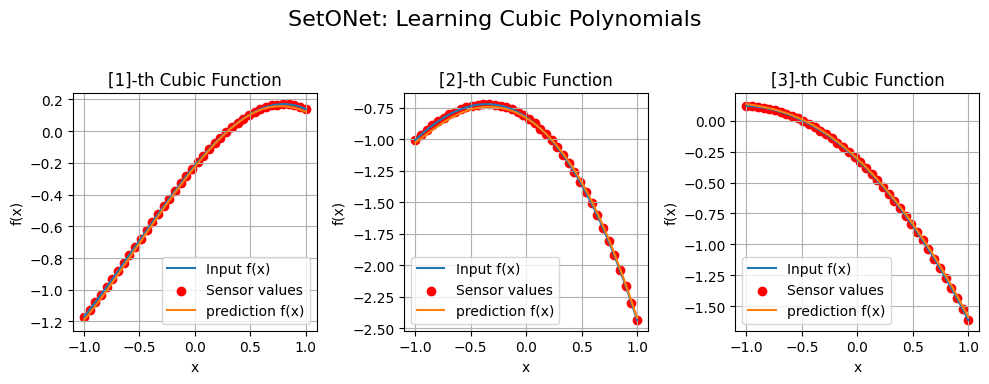

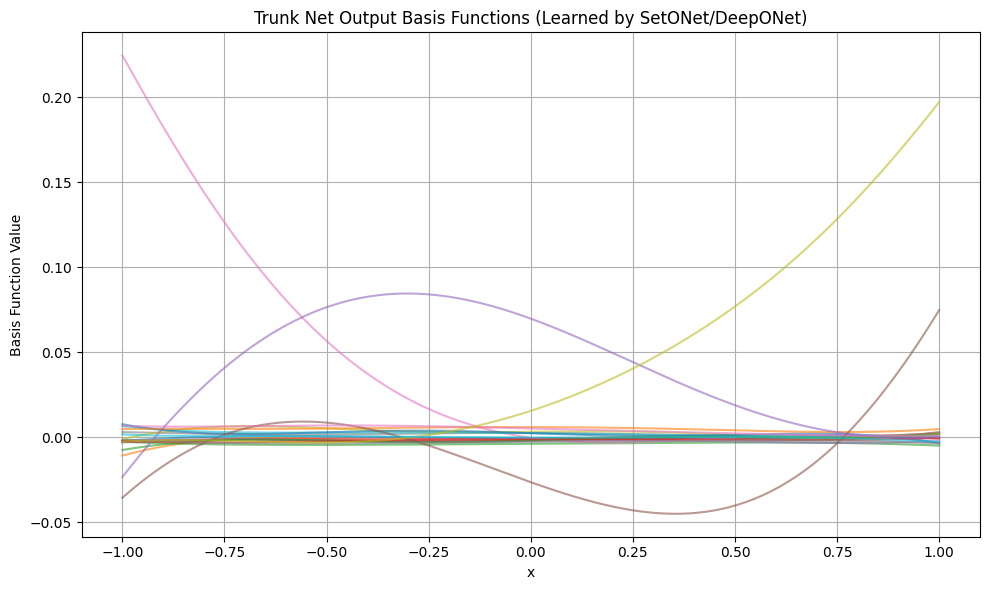

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

# some hyperparmeters for the problem
l1_lambda = 5e-5
input_range = [-1,1]
scale = 1
sensor_size = 40

# Sensor points (fixed for branch input)
sensor_x = torch.linspace(input_range[0], input_range[1], sensor_size)  # e.g., 40 equidistant points

# Trunk input points (evaluation x)
def sample_trunk_points(n_points):
    # return (input_range[1]-input_range[0]) * torch.rand(n_points, 1) + input_range[0]
    return torch.linspace(input_range[0], input_range[1], n_points).view(-1,1)

# Generate a batch of cubic polynomials
def generate_batch(batch_size, n_trunk_points):
    a = torch.rand(batch_size, 1) * 2 - 1
    b = torch.rand(batch_size, 1) * 2 - 1
    c = torch.rand(batch_size, 1) * 2 - 1
    d = torch.rand(batch_size, 1) * 2 - 1
    a, b, c, d = a * scale, b * scale, c * scale, d * scale


    f_values = a * sensor_x**3 + b * sensor_x**2 + c * sensor_x + d  # [B, S]
    # f_values = torch.cat([sensor_x.unsqueeze(0).expand(batch_size, -1).unsqueeze(-1), f_values.unsqueeze(-1)], dim=-1)  # [B, S, 2] use for DeepSets

    x = sample_trunk_points(n_trunk_points)  # [T, 1]
    y = a * x.T**3 + b * x.T**2 + c * x.T + d  # [B, T]
    return f_values, x, y

# Define DeepONet structure, even though only for single function space
# branch_net = DeepSets(input_dim=2, hidden_dim=64, output_dim=20, aggregation='mean')
branch_net = MLP(input_dim=sensor_size, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh)
trunk_net = MLP(input_dim=1, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh)
model = DeepONet(branch_net=branch_net, trunk_net=trunk_net).to(device)

# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20000):
    model.train()
    branch_input, trunk_input, target = generate_batch(batch_size=64, n_trunk_points=40)
    branch_input = branch_input.to(device)
    trunk_input = trunk_input.to(device)
    target = target.to(device)
    pred = model(branch_input, trunk_input)
    loss = loss_fn(pred, target)
    trunk_output = model.trunk_net(trunk_input)
    l1_reg = l1_lambda * torch.norm(trunk_output, p=1)
    loss  += l1_reg

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

model.eval()
# l2 relative error over large batch
with torch.no_grad():
    n_test = 1000
    branch_input, trunk_input, y_true = generate_batch(batch_size=n_test, n_trunk_points=100)
    branch_input = branch_input.to(device)
    trunk_input = trunk_input.to(device)
    y_true = y_true.to(device)
    y_pred = model(branch_input, trunk_input)
    error = torch.norm(y_pred - y_true, dim=1)
    denom = torch.norm(y_true, dim=1)
    rel_error = (error / denom).mean()
    print(f"\nAverage L2 Relative Error over {n_test} test examples: {rel_error:.6f}")

x_dense = torch.linspace(input_range[0], input_range[1], 200)  # [200]
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("SetONet: Learning Cubic Polynomials", fontsize=16)
for i in range(3):
    # Random cubic coefficients
    a = 2*torch.rand(1).item()-1
    b = 2*torch.rand(1).item()-1
    c = 2*torch.rand(1).item()-1
    d = 2*torch.rand(1).item()-1

    # Compute input (function values at sensor points)
    f_sensor = a * sensor_x**3 + b * sensor_x**2 + c * sensor_x + d  # [S]
    f_dense = a * x_dense**3 + b * x_dense**2 + c * x_dense + d  # [200]

    # Prepare DeepONet input: branch_input should be [B, S, 2], we simulate batch_size = 1
    # branch_input = torch.stack([sensor_x.unsqueeze(0), f_sensor.unsqueeze(0)], dim=-1)  # [1, S, 2] as branch input for a single batch
    branch_input = f_sensor.unsqueeze(0)  # [1, S] as branch input for a single batch
    branch_input = branch_input.to(device)

    # Compute predictions for the dense x values
    with torch.no_grad():
        f_pred = model(branch_input, x_dense.view(-1,1).to(device)).squeeze().cpu()  # [200]

    # Plot function input (cubic polynomial)
    axs[i].plot(x_dense, f_dense, label="Input f(x)")  # Dense f(x)
    axs[i].scatter(sensor_x, f_sensor, color="red", label="Sensor values")  # Sensor points
    axs[i].plot(x_dense, f_pred, label="prediction f(x)")  # Sensor points
    axs[i].set_title(f"[{i+1}]-th Cubic Function")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("f(x)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ---- Visualize trunk net basis functions over the domain ----
x_basis = torch.linspace(input_range[0], input_range[1], 200).view(-1, 1).to(device)  # [200, 1]

with torch.no_grad():
    trunk_out = model.trunk_net(x_basis).cpu()  # [200, hidden_dim]
    trunk_out_np = trunk_out.numpy()

plt.figure(figsize=(10, 6))
for i in range(trunk_out_np.shape[1]):
    plt.plot(x_basis.squeeze().detach().cpu().numpy(), trunk_out_np[:, i], label=f"Basis {i+1}", alpha=0.6)

plt.title("Trunk Net Output Basis Functions (Learned by SetONet/DeepONet)")
plt.xlabel("x")
plt.ylabel("Basis Function Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## Implementation for FE-DeepONet

similar idea to RINO, use FE for handling input functions over variable sensor locations, pass the encoding to a standard DeepONet for the rest of the operator learning setup.

In [ ]:
!git clone https://github.com/tyler-ingebrand/FunctionEncoder.git
%cd FunctionEncoder/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union
from FunctionEncoder.Dataset.BaseDataset import BaseDataset

# need to first defien a dataset for function encoder to learn cubic polynomials
class CubicDataset(BaseDataset):
    def __init__(self,
                 a_range=(-3, 3),
                 b_range=(-3, 3),
                 c_range=(-3, 3),
                 d_range=(-3, 3),
                 input_range=(-10, 10),
                 device: str = "auto",
                 dtype: torch.dtype = torch.float32,
                 n_functions:int=None,
                 n_examples:int=None,
                 n_queries:int=None,):
        # default arguments here
        if n_functions is None:
            n_functions = 10
        if n_examples is None:
            n_examples = 100
        if n_queries is None:
            n_queries = 1000

        super().__init__(input_size=(1,),
                         output_size=(1,),
                         data_type="deterministic",
                         device=device,
                         dtype=dtype,
                         n_functions=n_functions,
                         n_examples=n_examples,
                         n_queries=n_queries,)
        self.a_range = torch.tensor(a_range, device=self.device, dtype=self.dtype)
        self.b_range = torch.tensor(b_range, device=self.device, dtype=self.dtype)
        self.c_range = torch.tensor(c_range, device=self.device, dtype=self.dtype)
        self.d_range = torch.tensor(d_range, device=self.device, dtype=self.dtype)
        self.input_range = torch.tensor(input_range, device=self.device, dtype=self.dtype)

    def sample(self) -> Tuple[  torch.tensor,
                                torch.tensor,
                                torch.tensor,
                                torch.tensor,
                                dict]:
        with torch.no_grad():
            n_functions = self.n_functions
            n_examples = self.n_examples
            n_queries = self.n_queries
            # generate n_functions sets of coefficients
            As = torch.rand((n_functions, 1), dtype=self.dtype, device=self.device) * (self.a_range[1] - self.a_range[0]) + self.a_range[0]
            Bs = torch.rand((n_functions, 1), dtype=self.dtype, device=self.device) * (self.b_range[1] - self.b_range[0]) + self.b_range[0]
            Cs = torch.rand((n_functions, 1), dtype=self.dtype, device=self.device) * (self.c_range[1] - self.c_range[0]) + self.c_range[0]
            Ds = torch.rand((n_functions, 1), dtype=self.dtype, device=self.device) * (self.d_range[1] - self.d_range[0]) + self.d_range[0]
            # generate n_samples_per_function samples for each function
            query_xs = torch.rand((n_functions, n_queries, *self.input_size), dtype=self.dtype, device=self.device)
            query_xs = query_xs * (self.input_range[1] - self.input_range[0]) + self.input_range[0]
            example_xs = torch.rand((n_functions, n_examples, *self.input_size), dtype=self.dtype, device=self.device)
            example_xs = example_xs * (self.input_range[1] - self.input_range[0]) + self.input_range[0]
            # compute the corresponding ys
            query_ys = As.unsqueeze(1) * query_xs ** 3 + Bs.unsqueeze(1) * query_xs **2 + Cs.unsqueeze(1) * query_xs + Ds.unsqueeze(1)
            example_ys = As.unsqueeze(1) * example_xs ** 3 + Bs.unsqueeze(1) * example_xs **2 + Cs.unsqueeze(1) * example_xs + Ds.unsqueeze(1)

            return example_xs, example_ys, query_xs, query_ys, {"As":As, "Bs" : Bs, "Cs": Cs, "Ds": Ds}

In [ ]:
# set a function encoder to learn the cubic polynomial space
from datetime import datetime
from FunctionEncoder import FunctionEncoder, MSECallback, ListCallback, TensorboardCallback, DistanceCallback

# hyperparameters
n_basis = 20
train_method = "least_squares"
epochs = 5000
seed = 0
logdir = f"logs_cubic_example_{train_method}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
arch = "MLP"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

# seed torch
torch.manual_seed(seed)
np.random.seed(seed)
a_range = b_range = c_range = d_range = (-1, 1)
input_range = (-1, 1)

# create dataset
dataset = CubicDataset(a_range=a_range, b_range=b_range, c_range=c_range, input_range=input_range)

# create the model
model = FunctionEncoder(input_size=dataset.input_size,
                        output_size=dataset.output_size,
                        data_type=dataset.data_type,
                        n_basis=n_basis,
                        model_type=arch,
                        method=train_method).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
cb1 = TensorboardCallback(logdir) # this one logs training data
cb2 = DistanceCallback(dataset, tensorboard=cb1.tensorboard) # this one tests and logs the results
callback = ListCallback([cb1, cb2])
# train the model
model.train_model(dataset, epochs=epochs, callback=callback)
# save the model
torch.save(model.state_dict(), f"{logdir}/model.pth")


# plot
with torch.no_grad():
    n_plots = 9
    n_examples = 100
    example_xs, example_ys, query_xs, query_ys, info = dataset.sample()
    example_xs, example_ys = example_xs[:, :n_examples, :], example_ys[:, :n_examples, :]
    if train_method == "inner_product":
        y_hats_ip = model.predict_from_examples(example_xs, example_ys, query_xs, method="inner_product")
    y_hats_ls = model.predict_from_examples(example_xs, example_ys, query_xs, method="least_squares")
    query_xs, indicies = torch.sort(query_xs, dim=-2)
    query_ys = query_ys.gather(dim=-2, index=indicies)
    y_hats_ls = y_hats_ls.gather(dim=-2, index=indicies)
    if train_method == "inner_product":
        y_hats_ip = y_hats_ip.gather(dim=-2, index=indicies)

    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    for i in range(n_plots):
        ax = axs[i // 3, i % 3]
        ax.plot(query_xs[i].cpu(), query_ys[i].cpu(), label="True")
        ax.plot(query_xs[i].cpu(), y_hats_ls[i].cpu(), label="LS")
        if train_method == "inner_product":
            ax.plot(query_xs[i].cpu(), y_hats_ip[i].cpu(), label="IP")
        if i == n_plots - 1:
            ax.legend()
        title = f"${info['As'][i].item():.2f}x^3 + {info['Bs'][i].item():.2f}x^2 + {info['Cs'][i].item():.2f}x + {info['Ds'][i].item():.2f}$"
        ax.set_title(title)
        y_min, y_max = query_ys[i].min().item(), query_ys[i].max().item()
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.savefig(f"{logdir}/plot.png")
    plt.clf()

    # plot the basis functions
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    query_xs = torch.linspace(input_range[0], input_range[1], 1_000).reshape(1000, 1).to(device)
    basis = model.forward_basis_functions(query_xs)
    for i in range(n_basis):
        ax.plot(query_xs.flatten().cpu(), basis[:, 0, i].cpu(), color="black")

    plt.tight_layout()
    plt.savefig(f"{logdir}/basis.png")
    plt.close()

# evaluate model
dataset = CubicDataset(a_range=a_range, b_range=b_range, c_range=c_range, d_range=d_range, input_range=input_range, n_functions=2048, n_examples=100, n_queries=1000)
with torch.no_grad():
    example_xs, example_ys, query_xs, query_ys, info = dataset.sample()
    if train_method == "inner_product":
        y_hats = model.predict_from_examples(example_xs, example_ys, query_xs, method="inner_product")
    y_hats = model.predict_from_examples(example_xs, example_ys, query_xs, method="least_squares")
    query_ys = query_ys.squeeze(-1).cpu().numpy()
    y_hats   = y_hats.squeeze(-1).cpu().numpy()

    relative_errors = np.linalg.norm(y_hats - query_ys, axis=1) / np.linalg.norm(query_ys, axis=1)
    print('L2 Relative Error: ', np.mean(relative_errors))


device:  cuda
Number of parameters: 137236


100%|██████████| 5000/5000 [00:44<00:00, 113.02it/s]


L2 Relative Error:  0.013553489


<Figure size 1500x1000 with 0 Axes>

Epoch 0, Loss: 1.568198
Epoch 500, Loss: 0.002670
Epoch 1000, Loss: 0.001233
Epoch 1500, Loss: 0.006239
Epoch 2000, Loss: 0.001048
Epoch 2500, Loss: 0.003069
Epoch 3000, Loss: 0.001346
Epoch 3500, Loss: 0.001016
Epoch 4000, Loss: 0.003071
Epoch 4500, Loss: 0.000704


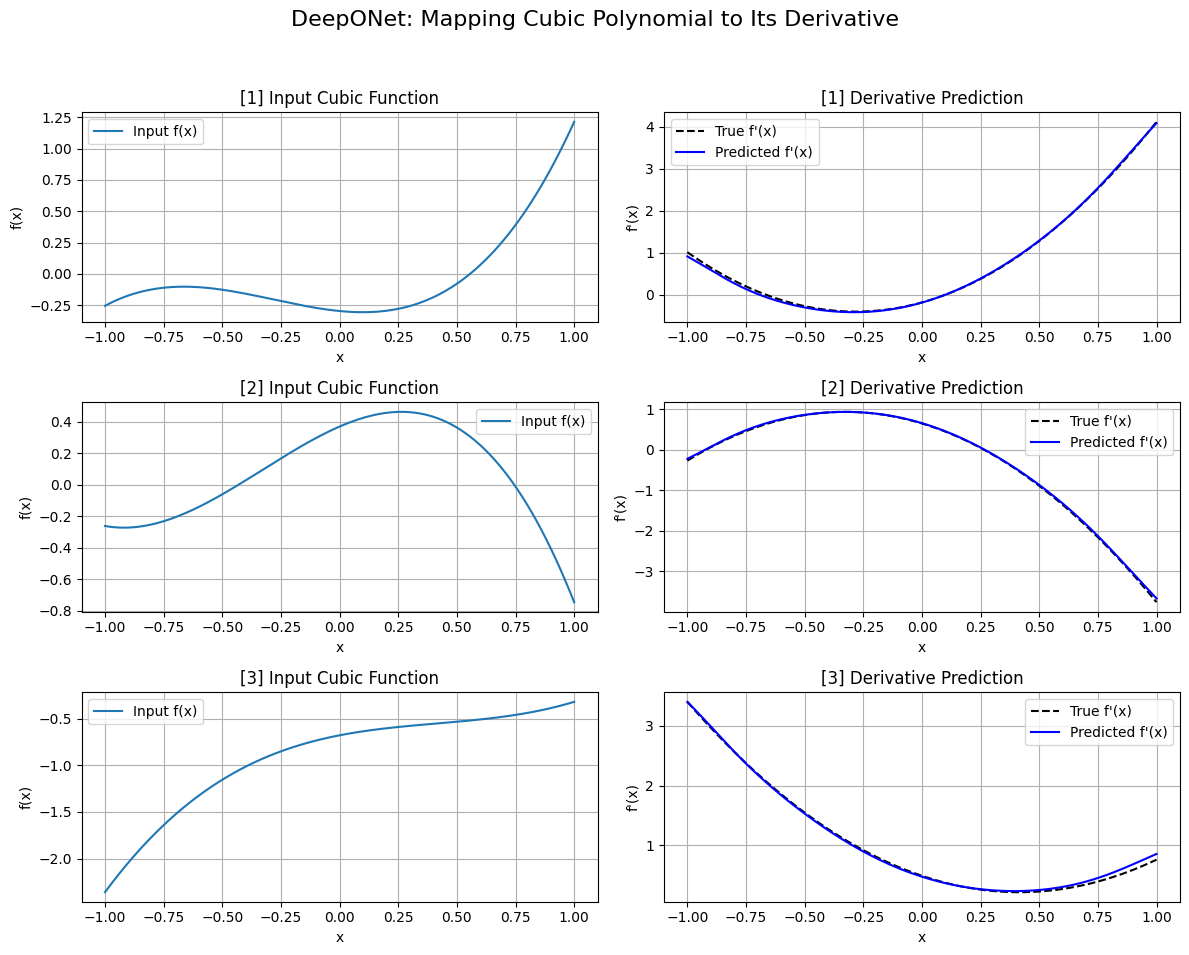


Average L2 Relative Error over 1000 test examples: 0.028787


In [ ]:
# now set up the RINO like solver by combining the pretrained function encoder with standard DeepONet architecture

# Fix random seed
torch.manual_seed(0)
np.random.seed(0)

dataset = CubicDataset(a_range=a_range, b_range=b_range, c_range=c_range, input_range=input_range)
def generate_batch(model, n_trunk_points):
    example_xs, example_ys, _, _, info = dataset.sample()
    batch_size = example_xs.shape[0]
    representation, _ = model.compute_representation(example_xs, example_ys, method = train_method) # shape batch size * n_basis
    As, Bs, Cs, Ds = info["As"], info["Bs"], info["Cs"], info["Ds"]

    x = torch.linspace(dataset.input_range[0], dataset.input_range[1], n_trunk_points, device = device).view(-1,1) # shape n_points * dim
    y = 3 * As * x.T**2 + 2 * Bs * x.T + Cs  # shape batch size * n_points

    return representation, x, y



# simple MLP calss
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# DeepONet model
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net

    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)  # [batch, p]
        t = self.trunk_net(trunk_input)    # [points, p]
        out = torch.matmul(b, t.T)  # scalar output
        return out

sample_size = 40
# Define DeepONet
branch_net = MLP(input_dim=n_basis, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh).to(device)
trunk_net = MLP(input_dim=1, hidden_dims=[64, 64], output_dim=20, activation=nn.Tanh).to(device)
deeponet_model = DeepONet(branch_net=branch_net, trunk_net=trunk_net)

# Training loop
optimizer = optim.Adam(deeponet_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(5000):
    deeponet_model.train()
    branch_input, trunk_input, target = generate_batch(model, n_trunk_points=sample_size)
    pred = deeponet_model(branch_input, trunk_input)
    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")




# Results and Visualization
deeponet_model.eval()
x_dense = torch.linspace(input_range[0], input_range[1], 200, device=device).view(-1,1)

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("DeepONet: Mapping Cubic Polynomial to Its Derivative", fontsize=16)

for i in range(3):
    example_xs, example_ys, _, _, info = dataset.sample()
    representation, _ = model.compute_representation(example_xs, example_ys, method = train_method) # shape batch size * n_basis
    a, b, c, d = info["As"][0].item(), info["Bs"][0].item(), info["Cs"][0].item(), info["Ds"][0].item()

    # Compute input (function values at sensor points)
    f_dense = a * x_dense.squeeze()**3 + b * x_dense.squeeze()**2 + c * x_dense.squeeze() + d
    df_true = 3*a*x_dense.squeeze()**2 + 2*b*x_dense.squeeze() + c

    # Prepare DeepONet input
    branch_input = representation
    with torch.no_grad():
        df_pred = deeponet_model(branch_input, x_dense)[0,:]

    # Plot function input (cubic polynomial)
    axs[i, 0].plot(x_dense.squeeze().detach().cpu().numpy(), f_dense.detach().cpu().numpy(), label="Input f(x)")
    axs[i, 0].set_title(f"[{i+1}] Input Cubic Function")
    axs[i, 0].set_xlabel("x")
    axs[i, 0].set_ylabel("f(x)")
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Plot true vs predicted derivative
    axs[i, 1].plot(x_dense.squeeze().detach().cpu().numpy(), df_true.detach().cpu().numpy(), 'k--', label="True f'(x)")
    axs[i, 1].plot(x_dense.squeeze().detach().cpu().numpy(), df_pred.detach().cpu().numpy(), 'b-', label="Predicted f'(x)")
    axs[i, 1].set_title(f"[{i+1}] Derivative Prediction")
    axs[i, 1].set_xlabel("x")
    axs[i, 1].set_ylabel("f'(x)")
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


n_test = 1000
dataset = CubicDataset(a_range=a_range, b_range=b_range, c_range=c_range, input_range=input_range, n_functions=n_test)
branch_input, trunk_input, y_true = generate_batch(model, n_trunk_points=100)
y_pred = deeponet_model(branch_input, trunk_input)

error = torch.norm(y_pred - y_true, dim=1)
denom = torch.norm(y_true, dim=1)
rel_error = (error / denom).mean()
print(f"\nAverage L2 Relative Error over {n_test} test examples: {rel_error:.6f}")



torch.save(deeponet_model.state_dict(), f"{logdir}/deeponet_model.pth")
